In [1]:
pip install sweetviz phik shap catboost -q

Note: you may need to restart the kernel to use updated packages.


# Классификация музыки

**Цель работы:** разработать модель, позволяющую классифицировать музыкальные произведения по жанрам.

Входные данные - датасет, подготовленный коллегами из отдела работы со звуком.

План работы:
1. [x] Открыть и ознакомиться с файлами с данными
2. [x] Произвести предобработку и исследовательский анализ данных
    - [x] Проверить данные и откорректировать их, если потребуется
    - [x] Провести исследовательский анализ представленных данных
3. [x] Подготовить данный для последующего обучения модели
    - [x] разработать новые синтетические признаки
    - [x] выполнить проверку на мультиколлинеарность
    - [x] отобрать финальный набор обучающих признаков
4. [x] Разработать модель ML
    - [x] Обучить разные модели и оценить их качество
5. [x] Провести итоговую оценку качества предсказания лучшей модели
6. [x] Выполнить анализ важности признаков лучшей модели
7. [x] Написать общий вывод

Описание полей данных

- **instance_id** - Уникальный идентификатор трека
- **track_name** - Название трека
acousticness - Мера уверенности от 0,0 до 1,0 в том, что трек является акустическим. 1,0 означает высокую степень уверенности в том, что трек является акустическим.
- **danceability** - Танцевальность описывает, насколько трек подходит для танцев, основываясь на сочетании музыкальных элементов, включая темп, стабильность ритма, силу ударов и общую регулярность. Значение 0,0 означает наименьшую танцевальность, а 1,0 - наибольшую танцевальность.
duration_ms - Продолжительность трека в миллисекундах.
energy - Энергия это показатель от 0,0 до 1,0, представляющий собой меру интенсивности и активности. Как правило, энергичные композиции ощущаются как быстрые, громкие и шумные. Например, дэт-метал обладает высокой энергией, в то время как прелюдия Баха имеет низкую оценку этого параметра
- **instrumentalness** - Определяет, содержит ли трек вокал. Звуки "Ooh" и "aah" в данном контексте рассматриваются как инструментальные. Рэп или разговорные треки явно являются "вокальными". Чем ближе значение инструментальности к 1,0, тем больше вероятность того, что трек не содержит вокала
- **key** - базовый ключ (нота) произведения
- **liveness** - Определяет присутствие аудитории в записи. Более высокие значения liveness означают увеличение вероятности того, что трек был исполнен вживую. Значение выше 0,8 обеспечивает высокую вероятность того, что трек исполняется вживую
- **loudness** - Общая громкость трека в децибелах (дБ)
mode - Указывает на модальность (мажорную или минорную) трека
speechiness - Речевой характер определяет наличие в треке разговорной речи. Чем более исключительно речевой характер носит запись (например, ток-шоу, аудиокнига, поэзия), тем ближе значение атрибута к 1,0. Значения выше 0,66 характеризуют треки, которые, вероятно, полностью состоят из разговорной речи. Значения от 0,33 до 0,66 характеризуют треки, которые могут содержать как музыку, так и речь, как в виде фрагментов, так и в виде слоев, включая такие случаи, как рэп-музыка. Значения ниже 0,33, скорее всего, представляют музыку и другие неречевые треки.
- **tempo** - Темп трека в ударах в минуту (BPM). В музыкальной терминологии темп представляет собой скорость или темп данного произведения и напрямую зависит от средней продолжительности тактов
- **obtained_date** - дата загрузки в сервис
- **valence** - Показатель от 0,0 до 1,0, характеризующий музыкальный позитив, передаваемый треком. Композиции с высокой валентностью звучат более позитивно (например, радостно, весело, эйфорично), а композиции с низкой валентностью - более негативно (например, грустно, депрессивно, сердито)
- **music_genre** - Музыкальный жанр трека

# 1. Знакомство с данными

Импортируем все необходимые для работы библиотеки.

In [2]:
import pandas as pd
import numpy as np
import sweetviz as sv
import matplotlib.pyplot as plt
import seaborn as sns
import phik
import shap
import regex
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier, Pool, cv
from sklearn.metrics import f1_score

Отроем представленные файлы с данными.

In [3]:
df_1 = pd.read_csv('kaggle_music_genre_train.csv')
df_2 = pd.read_csv('kaggle_music_genre_test.csv')

Создадим копии датасетов, чтобы не вносить изменения в исходный.

In [4]:
df_train = df_1.copy()
df_test = df_2.copy()

Рассмотрим представленные данные.

In [5]:
print(df_train.info())
df_train.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20394 entries, 0 to 20393
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   instance_id       20394 non-null  float64
 1   track_name        20394 non-null  object 
 2   acousticness      20394 non-null  float64
 3   danceability      20394 non-null  float64
 4   duration_ms       20394 non-null  float64
 5   energy            20394 non-null  float64
 6   instrumentalness  20394 non-null  float64
 7   key               19659 non-null  object 
 8   liveness          20394 non-null  float64
 9   loudness          20394 non-null  float64
 10  mode              19888 non-null  object 
 11  speechiness       20394 non-null  float64
 12  tempo             19952 non-null  float64
 13  obtained_date     20394 non-null  object 
 14  valence           20394 non-null  float64
 15  music_genre       20394 non-null  object 
dtypes: float64(11), object(5)
memory usage: 

,instance_id,track_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre
0,25143.0,Highwayman,0.480000,0.670,182653.0,0.351,0.017600,D,0.1150,-16.842,Major,0.0463,101.384,4-Apr,0.450,Country
1,26091.0,Toes Across The Floor,0.243000,0.452,187133.0,0.670,0.000051,A,0.1080,-8.392,Minor,0.0352,113.071,4-Apr,0.539,Rock
2,87888.0,First Person on Earth,0.228000,0.454,173448.0,0.804,0.000000,E,0.1810,-5.225,Minor,0.3710,80.980,4-Apr,0.344,Alternative
3,77021.0,No Te Veo - Digital Single,0.055800,0.847,255987.0,0.873,0.000003,G#,0.3250,-4.805,Minor,0.0804,116.007,4-Apr,0.966,Hip-Hop
4,20852.0,Chasing Shadows,0.227000,0.742,195333.0,0.575,0.000002,C,0.1760,-5.550,Major,0.0487,76.494,4-Apr,0.583,Alternative
5,43934.0,Eskimo Blue Day - Remastered,0.102000,0.308,392893.0,0.590,0.371000,D,0.1120,-11.703,Major,0.0345,145.758,4-Apr,0.496,Blues
6,23450.0,Living On My Own,0.000234,0.655,218267.0,0.687,0.000024,A,0.0869,-11.789,Minor,0.0337,123.923,4-Apr,0.411,Rock
7,28380.0,Para Machuchar Meu Coracao,0.953000,0.591,309813.0,0.109,0.357000,D#,0.0921,-17.975,Major,0.0449,130.597,4-Apr,0.395,Jazz
8,70054.0,In the Mood,0.195000,0.647,283373.0,0.595,0.000118,A#,0.1290,-8.416,Minor,0.0336,73.478,4-Apr,0.546,Jazz
9,74815.0,20.000 Volts,0.032300,0.537,237000.0,0.962,0.193000,C,0.1580,-2.749,Major,0.1210,160.031,4-Apr,0.430,Electronic


In [6]:
print(df_test.info())
df_test.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5099 entries, 0 to 5098
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   instance_id       5099 non-null   int64  
 1   track_name        5099 non-null   object 
 2   acousticness      5099 non-null   float64
 3   danceability      5099 non-null   float64
 4   duration_ms       5099 non-null   float64
 5   energy            5099 non-null   float64
 6   instrumentalness  5099 non-null   float64
 7   key               4941 non-null   object 
 8   liveness          5099 non-null   float64
 9   loudness          5099 non-null   float64
 10  mode              4950 non-null   object 
 11  speechiness       5099 non-null   float64
 12  tempo             4978 non-null   float64
 13  obtained_date     5099 non-null   object 
 14  valence           5099 non-null   float64
dtypes: float64(10), int64(1), object(4)
memory usage: 597.7+ KB
None


,instance_id,track_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence
0,48564,Low Class Conspiracy,0.301000,0.757,146213.0,0.679,0.000000,A#,0.3030,-7.136,Minor,0.3560,90.361,4-Apr,0.895
1,72394,The Hunter,0.538000,0.256,240360.0,0.523,0.008320,G#,0.0849,-5.175,Major,0.0294,78.385,4-Apr,0.318
2,88081,Hate Me Now,0.005830,0.678,284000.0,0.770,0.000000,A,0.1090,-4.399,Minor,0.2220,90.000,4-Apr,0.412
3,78331,Somebody Ain't You,0.020300,0.592,177354.0,0.749,0.000000,B,0.1220,-4.604,Major,0.0483,160.046,4-Apr,0.614
4,72636,Sour Mango,0.000335,0.421,-1.0,0.447,0.014800,D,0.0374,-8.833,Major,0.2020,73.830,4-Apr,0.121
5,74228,If You're Going to the City,0.919000,0.516,227267.0,0.192,0.000026,A#,0.1840,-18.983,Minor,0.0650,73.241,4-Apr,0.603
6,39106,21 Questions,0.388000,0.547,224427.0,0.807,0.000091,F#,0.0436,-4.083,Minor,0.3600,79.823,3-Apr,0.919
7,78829,Husbands And Wives,0.653000,0.591,190032.0,0.388,0.000214,F,0.1670,-8.069,Major,0.0267,105.977,3-Apr,0.122
8,91469,Slow Me Down,0.214000,0.597,196160.0,0.602,0.000320,G,0.3130,-4.990,Major,0.0292,91.999,4-Apr,0.262
9,54558,Me Pegó la Gana,0.640000,0.578,168533.0,0.514,0.000000,G,0.1440,-5.990,Major,0.0401,66.342,3-Apr,0.857


**Вывод по первому шагу:** открыли и изучили таблицы с данными.

Для работы представлены две таблицы, первая содержит данные для обучения модели, вторая - для тестирования. Таблица тестирования содержит 15 столбцов с данными, из которых 10 - типа float64, 1 - типа int64 и 4 - типа object. Таблица с данными для обучения содержит столбцы в количестве 11 - типа float64 и 5 - типа object. Строки в таблицах имеют соотношение количества примерно 1 к 4. На первый взгляд в обеих таблицах видны пропуски в колонках `key`, `mode` и `tempo`. Столбец `instance_id` тренировочного датафрейма имеет тип `float`, что может свидетельствовать о наличии неверных данных в нем.

Размер файлов является небольшим, поэтому нет необходимости в оптимизации занимаемого ими объема памяти.

Далее перейдем к предобработке и исследовательскому анализу данных.

# 2. Предобработка и исследовательский анализ данных

Проверим данные на наличие явных дубликатов.

In [7]:
df_train.duplicated().sum(), df_test.duplicated().sum()

(0, 0)

Явные дубликаты отсутствуют. Но стоит посмотреть на наличие дубликатов при разных жанрах и значениях уникального id.

In [8]:
df_train[df_train.drop(['music_genre', 'instance_id'], axis=1).duplicated(keep=False)].sort_values(by='track_name')

,instance_id,track_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre
7581,77103.0,'75 aka Stay With You,0.030700,0.712,371507.0,0.8270,0.795,C#,0.122,-7.331,Major,0.0414,126.001,4-Apr,0.3050,Jazz
17628,71962.0,'75 aka Stay With You,0.030700,0.712,371507.0,0.8270,0.795,C#,0.122,-7.331,Major,0.0414,126.001,4-Apr,0.3050,Electronic
15701,20145.0,(Your Love Keeps Lifting Me) Higher & Higher,0.176000,0.631,181067.0,0.6900,0.000,D,0.121,-6.676,Major,0.0531,94.574,4-Apr,0.9380,Blues
11638,60181.0,(Your Love Keeps Lifting Me) Higher & Higher,0.176000,0.631,181067.0,0.6900,0.000,D,0.121,-6.676,Major,0.0531,94.574,4-Apr,0.9380,Rock
20381,43672.0,1 on 1,0.000525,0.905,192840.0,0.6770,0.000,D,0.251,-7.987,Major,0.3450,140.882,4-Apr,0.5980,Rap
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3416,63663.0,wokeuplikethis*,0.013800,0.785,235535.0,0.6200,0.000,G#,0.150,-6.668,Major,0.2540,78.476,4-Apr,0.4780,Rap
20375,27588.0,アシタカとサン - Piano Solo Feature,0.975000,0.338,273400.0,0.1260,0.911,C#,0.107,-14.419,Major,0.0284,79.882,4-Apr,0.0648,Classical
993,38507.0,アシタカとサン - Piano Solo Feature,0.975000,0.338,273400.0,0.1260,0.911,C#,0.107,-14.419,Major,0.0284,79.882,4-Apr,0.0648,Anime
10093,24851.0,花水木の咲く頃 - 辻井伸行,0.994000,0.270,209600.0,0.0171,0.921,E,0.145,-31.429,Major,0.0410,70.931,4-Apr,0.1470,Classical


Удаление столбцов `instance_id` и `music_genre` позволяет обнеаружить 962 явных дубликата. Их удаление может положительно сказаться на качестве модели.


In [9]:
df_train = df_train.drop_duplicates(subset=['track_name', 'acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'key', 'liveness', 'loudness', 'mode',
       'speechiness', 'tempo', 'obtained_date', 'valence'], keep=False)
df_train

,instance_id,track_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre
0,25143.0,Highwayman,0.48000,0.670,182653.0,0.351,0.017600,D,0.1150,-16.842,Major,0.0463,101.384,4-Apr,0.450,Country
1,26091.0,Toes Across The Floor,0.24300,0.452,187133.0,0.670,0.000051,A,0.1080,-8.392,Minor,0.0352,113.071,4-Apr,0.539,Rock
3,77021.0,No Te Veo - Digital Single,0.05580,0.847,255987.0,0.873,0.000003,G#,0.3250,-4.805,Minor,0.0804,116.007,4-Apr,0.966,Hip-Hop
4,20852.0,Chasing Shadows,0.22700,0.742,195333.0,0.575,0.000002,C,0.1760,-5.550,Major,0.0487,76.494,4-Apr,0.583,Alternative
5,43934.0,Eskimo Blue Day - Remastered,0.10200,0.308,392893.0,0.590,0.371000,D,0.1120,-11.703,Major,0.0345,145.758,4-Apr,0.496,Blues
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20389,47396.0,O Pato,0.71900,0.725,-1.0,0.483,0.000000,NaN,0.0797,-13.314,Minor,0.0438,87.413,4-Apr,0.942,Jazz
20390,44799.0,Mt. Washington,0.19000,0.482,198933.0,0.362,0.005620,F#,0.0913,-10.358,Minor,0.0299,76.879,4-Apr,0.174,Rock
20391,33350.0,Original Prankster,0.00061,0.663,220947.0,0.886,0.000025,D,0.2840,-4.149,Major,0.0358,146.803,4-Apr,0.942,Alternative
20392,77920.0,4Peat,0.00310,0.914,162214.0,0.515,0.000000,C#,0.1050,-9.934,Major,0.3560,150.016,4-Apr,0.215,Rap


Проверим столбец `instance_id` тренировочного датафрейма на наличие в нем ошибок.

Подозрительных значений нет, изменим тип данных на `int`.

In [10]:
df_train['instance_id'] = df_train['instance_id'].astype(int)

Далее рассмотрим все числовые признаки.

In [11]:
df_train.describe()

,instance_id,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
count,19432.000000,19432.000000,19432.000000,1.943200e+04,19432.000000,19432.000000,19432.000000,19432.000000,19432.000000,18990.000000,19432.000000
mean,55999.907061,0.278930,0.559931,2.198857e+05,0.622565,0.164706,0.198599,-8.632368,0.090136,121.021362,0.462905
std,20730.147419,0.324186,0.172224,1.289323e+05,0.253355,0.310093,0.167621,5.578561,0.096826,30.453307,0.244242
min,20011.000000,0.000000,0.060000,-1.000000e+00,0.001010,0.000000,0.013600,-44.406000,0.022300,34.765000,0.000000
25%,38140.750000,0.015600,0.449000,1.763568e+05,0.465000,0.000000,0.097200,-10.368500,0.035600,95.957250,0.269000
50%,56086.000000,0.124000,0.568000,2.192650e+05,0.664000,0.000168,0.129000,-7.093000,0.048700,120.015000,0.455000
75%,73967.250000,0.480000,0.681000,2.664132e+05,0.830000,0.100000,0.251000,-5.066000,0.092925,141.980750,0.653000
max,91758.000000,0.996000,0.978000,4.497994e+06,0.999000,0.996000,1.000000,3.744000,0.942000,220.041000,0.992000


In [12]:
df_test.describe()

,instance_id,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
count,5099.000000,5099.000000,5099.000000,5.099000e+03,5099.000000,5099.000000,5099.000000,5099.000000,5099.000000,4978.000000,5099.000000
mean,55643.871347,0.276324,0.561888,2.173974e+05,0.622030,0.165198,0.197924,-8.630186,0.092718,121.246463,0.465593
std,20762.384803,0.322657,0.170502,1.156374e+05,0.251829,0.311940,0.166241,5.619766,0.100130,29.875950,0.244217
min,20012.000000,0.000002,0.059600,-1.000000e+00,0.001540,0.000000,0.020400,-46.122000,0.022600,37.114000,0.020500
25%,37571.000000,0.016600,0.451000,1.737335e+05,0.465000,0.000000,0.096950,-10.231000,0.035700,96.070250,0.272000
50%,55246.000000,0.120000,0.568000,2.175000e+05,0.660000,0.000157,0.129000,-7.135000,0.048700,120.053500,0.458000
75%,73702.000000,0.460000,0.681000,2.642470e+05,0.826000,0.092750,0.248000,-5.127000,0.096550,141.934250,0.650000
max,91709.000000,0.996000,0.977000,1.360027e+06,0.999000,0.994000,0.990000,1.949000,0.918000,216.029000,0.982000


Представленные признаки не имеют подозрительных значений, за исключением отрицательной продолжительности трека.

In [13]:
(df_train['duration_ms'] <= 0).sum(), (df_test['duration_ms'] <= 0).sum()

(1995, 509)

Видим, что немалая часть треков имеет неположительную продолжительность. Удаление данных строк может значительно сказаться на результате. Средняя и медианная продолжительности треков практически равны в обоих датафреймах, заменим неположительные значения продолжительности средним.

In [14]:
def mean_duration_fill(data):
    mean_duration = data.query('duration_ms > 0')['duration_ms'].mean()
    return data['duration_ms'].apply(lambda x: mean_duration if x <= 0 else x)

df_train['duration_ms'] = mean_duration_fill(df_train)
df_test['duration_ms'] = mean_duration_fill(df_test)

Определим количество и долю пропусков в колонках.

In [15]:
df_train.isna().sum().to_frame().style.background_gradient('Reds')

,0
instance_id,0
track_name,0
acousticness,0
danceability,0
duration_ms,0
energy,0
instrumentalness,0
key,735
liveness,0
loudness,0


In [16]:
df_test.isna().sum().to_frame().style.background_gradient('Reds')

,0
instance_id,0
track_name,0
acousticness,0
danceability,0
duration_ms,0
energy,0
instrumentalness,0
key,158
liveness,0
loudness,0


Далее заполним пропуски в столбцах `key` и `mode` наиболее часто встречающимися значениями, а для`tempo` воспользуемся интерполяцией.

In [17]:
def fill(data):
    key_mode = data['key'].mode().item()
    data['key'] = data['key'].fillna(key_mode)
    mode_mode = data['mode'].mode().item()
    data['mode'] = data['mode'].fillna(mode_mode)
    data['tempo'] = data['tempo'].interpolate(method='linear')

fill(df_train)
fill(df_test)

Произведем исследовательский анализ данных методами библиотеки `sweetviz`.

                                             |                                             | [  0%]   00:00 ->…


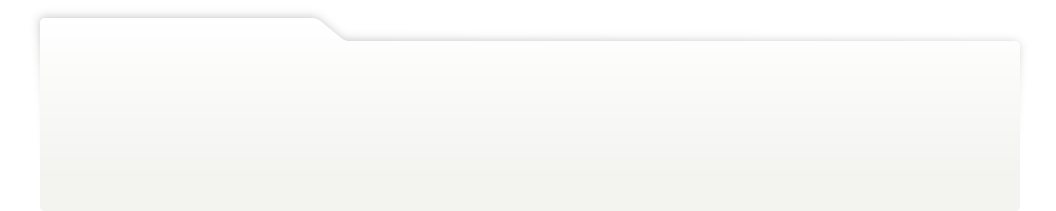
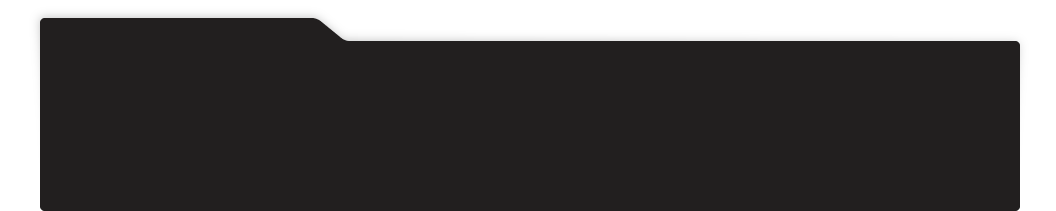
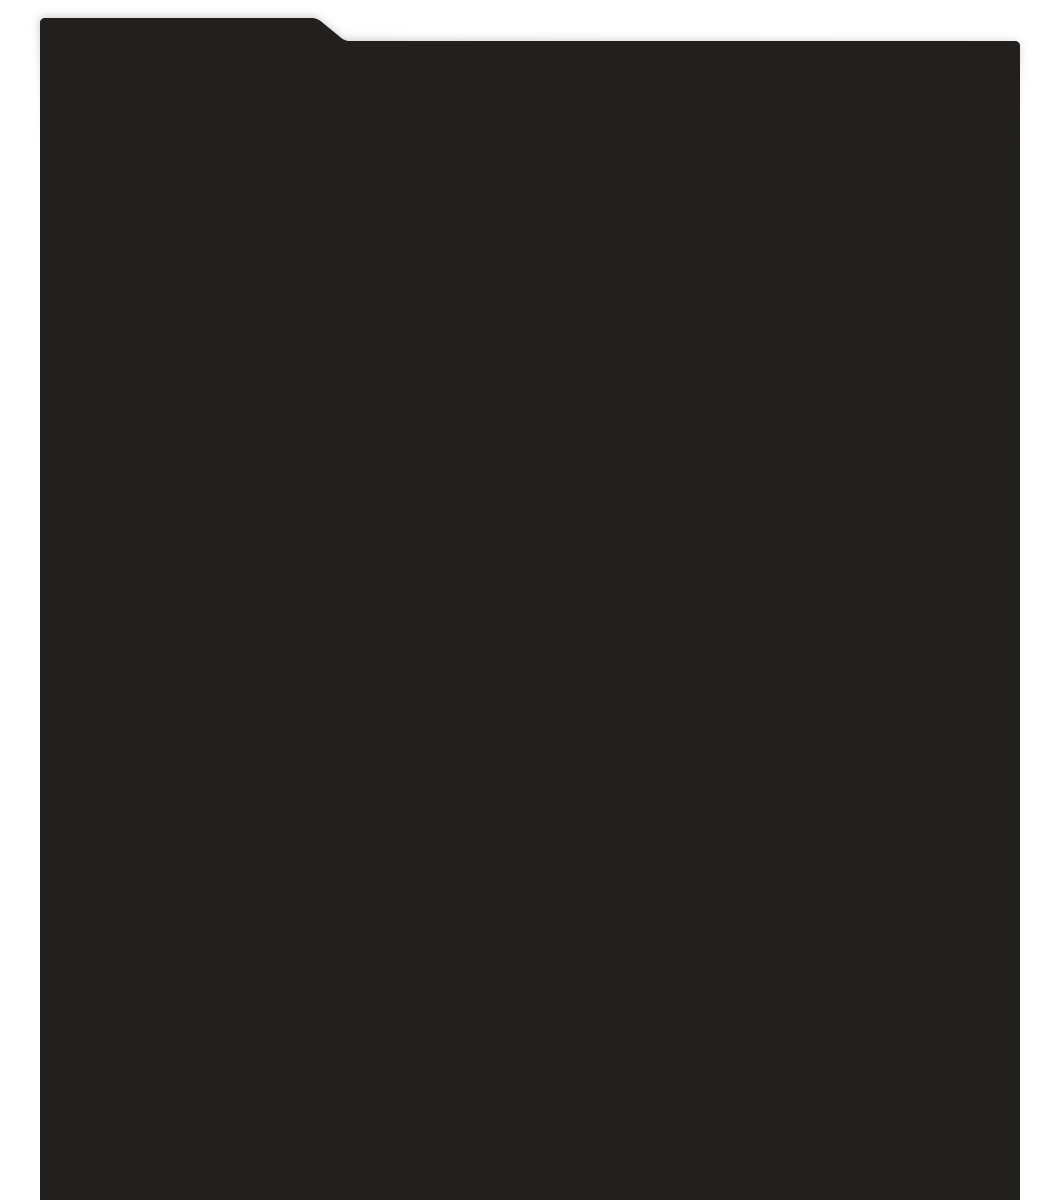
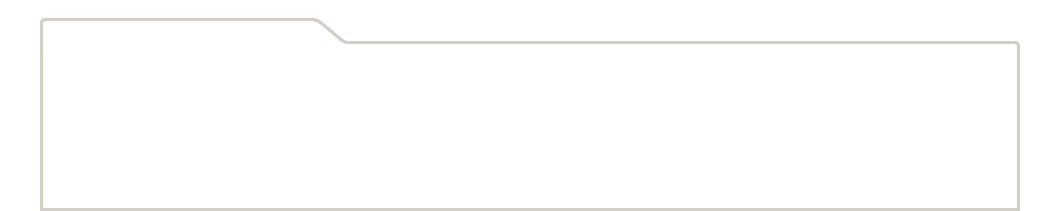
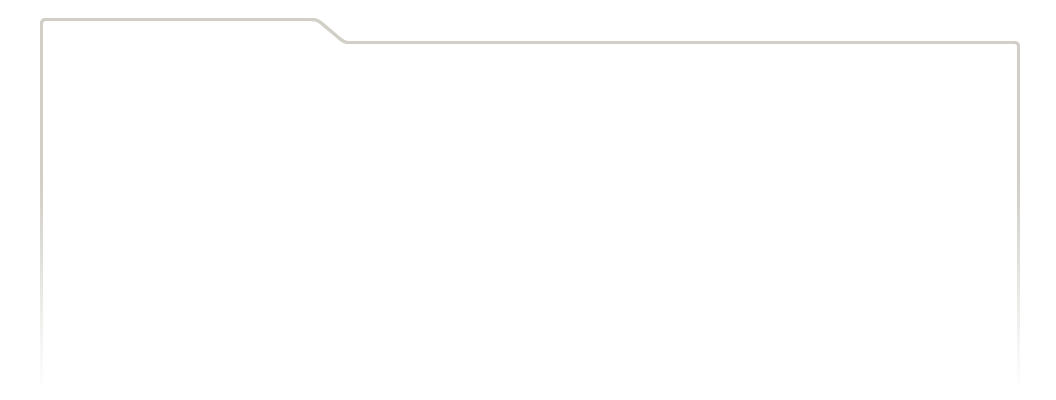
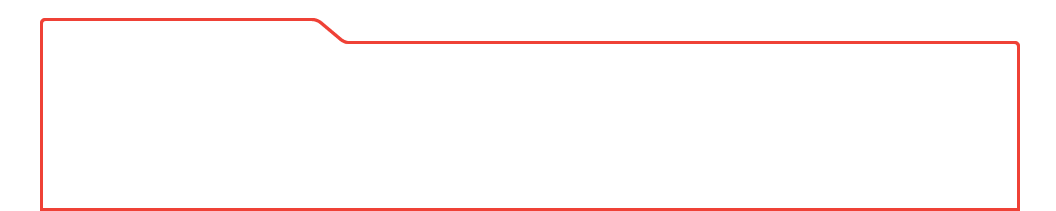
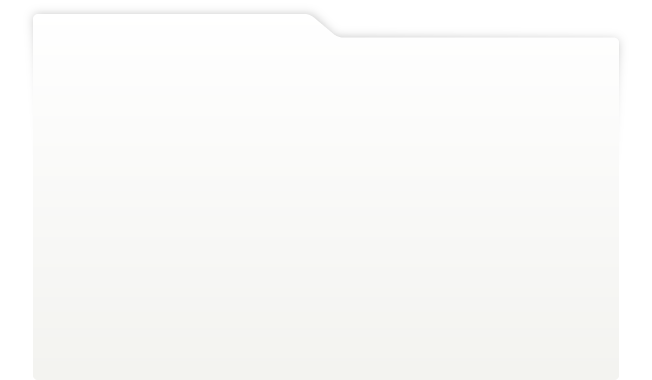
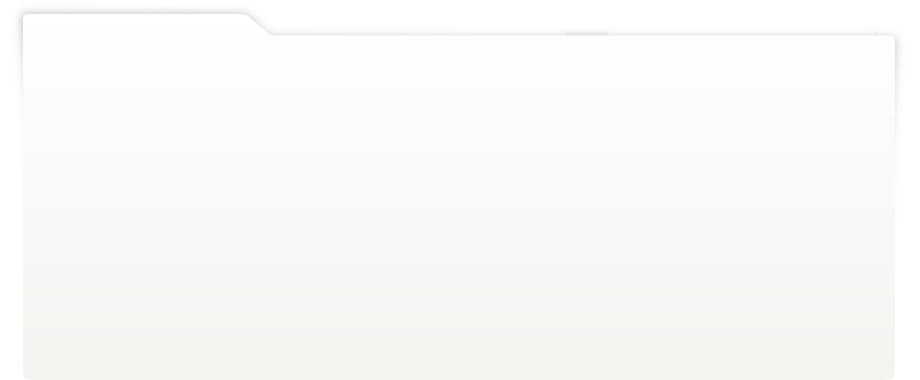
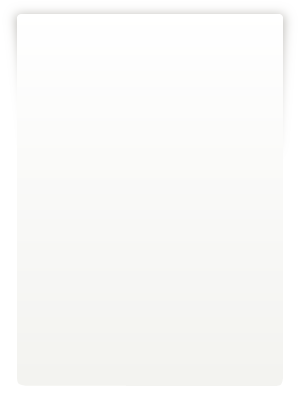
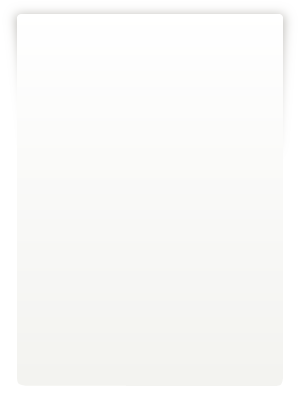
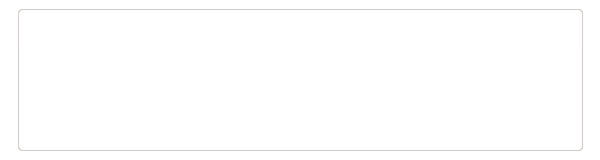
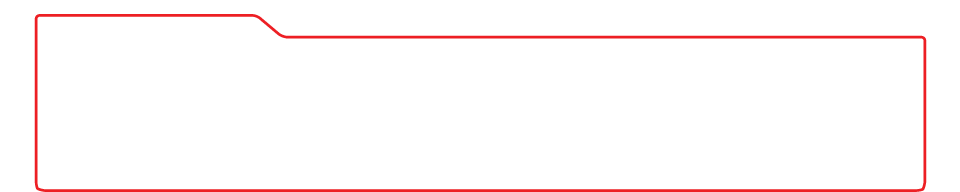
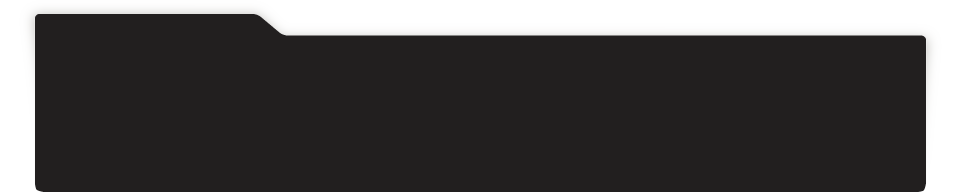
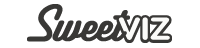
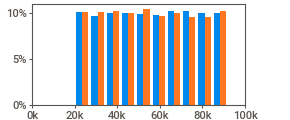
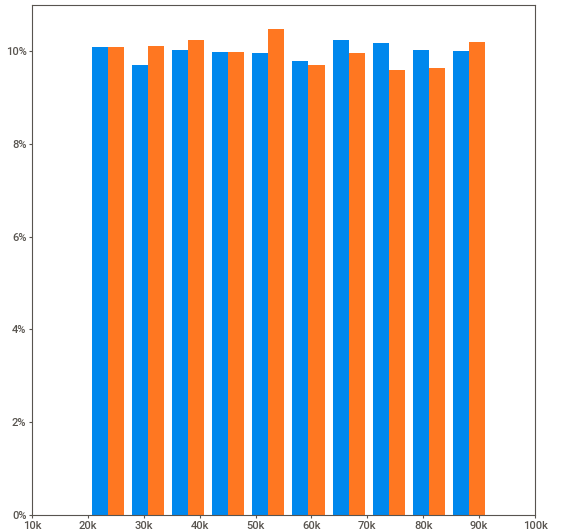
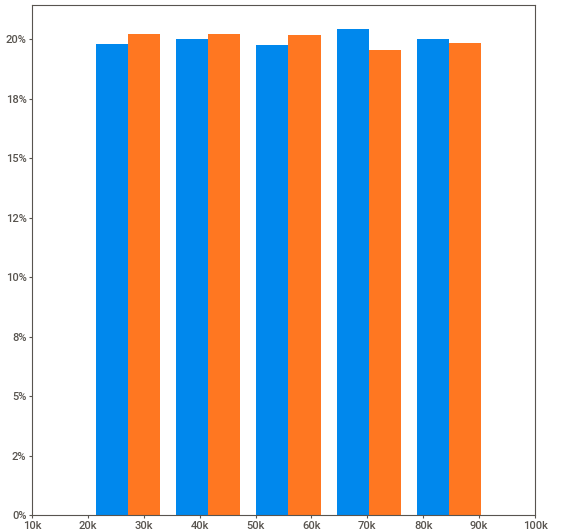
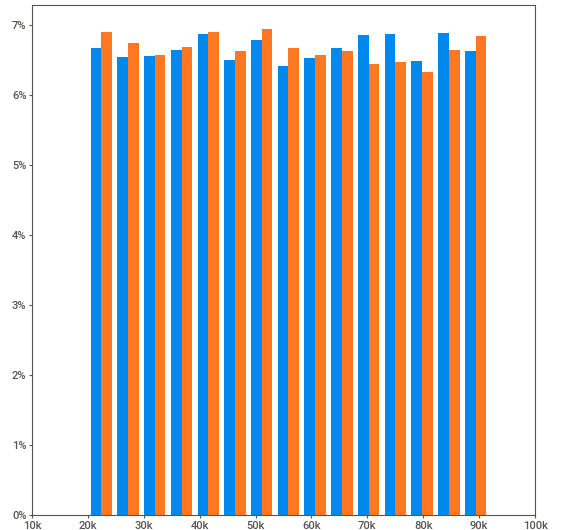
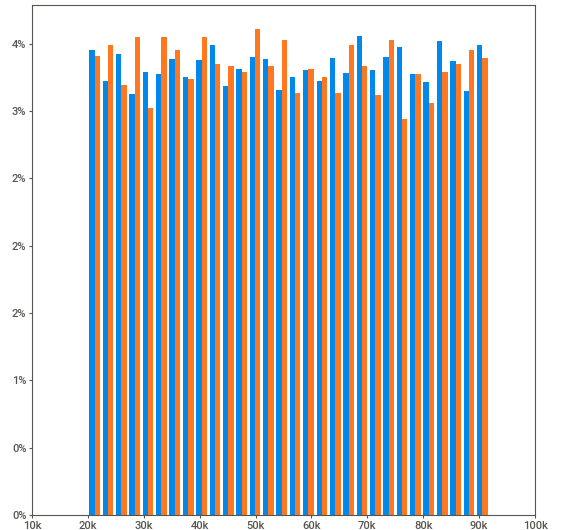
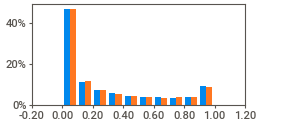
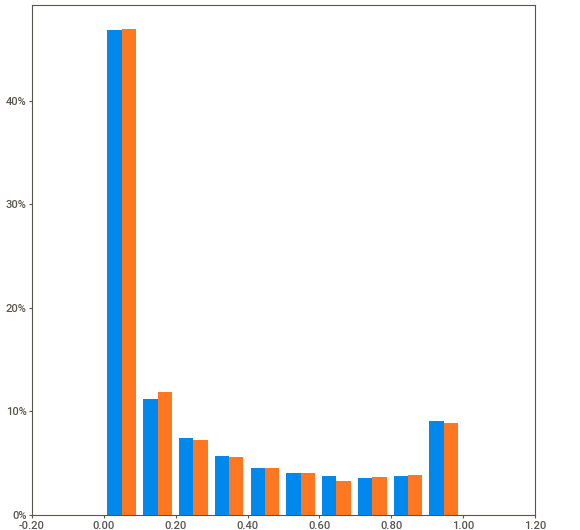
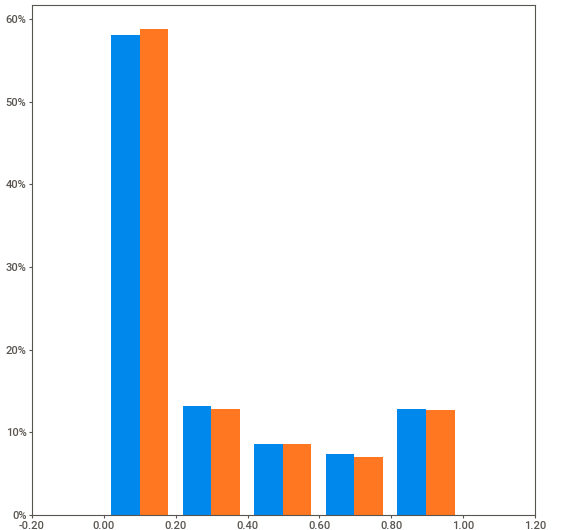
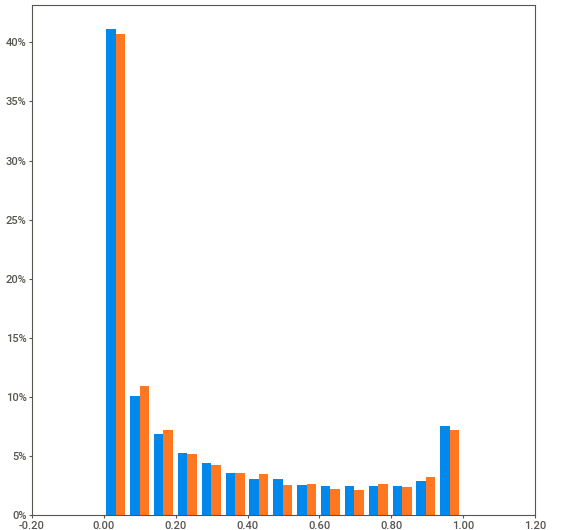
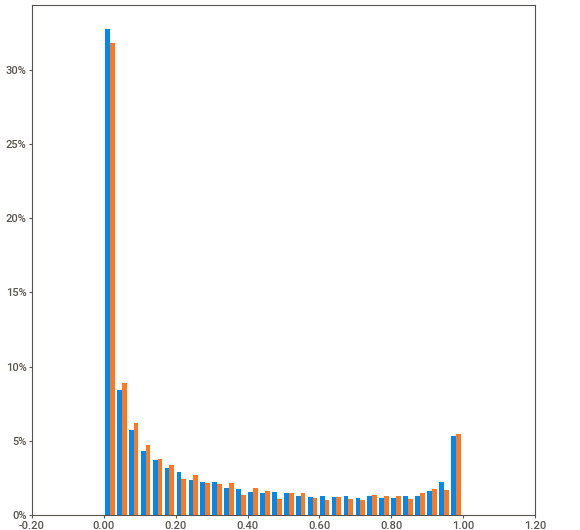
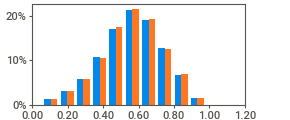
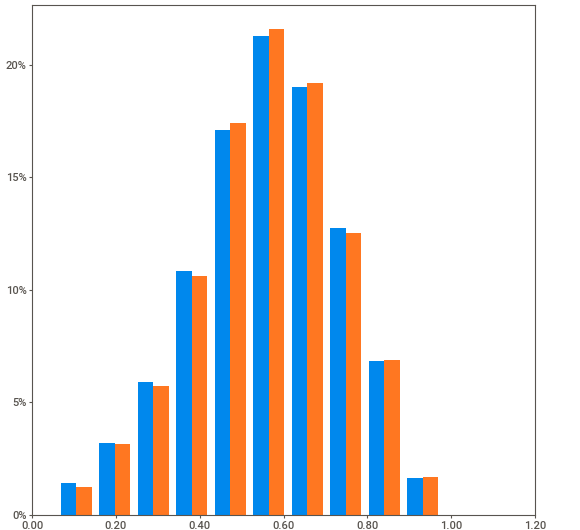
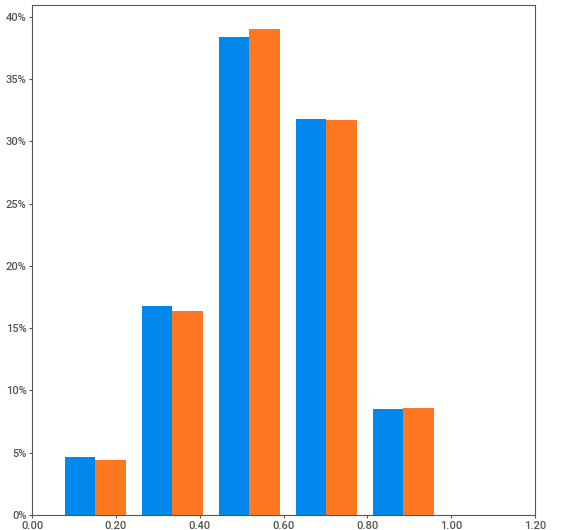
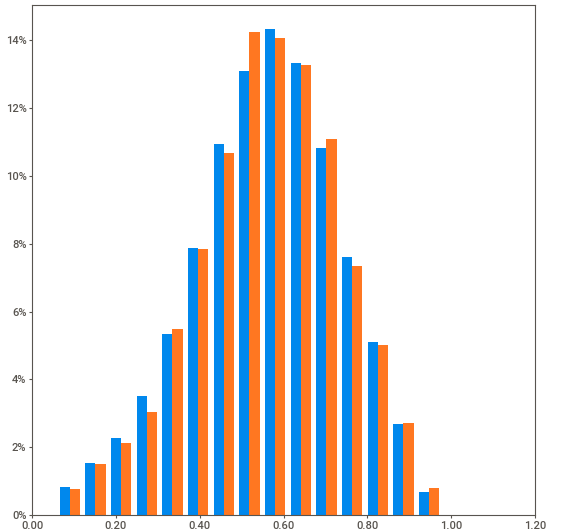
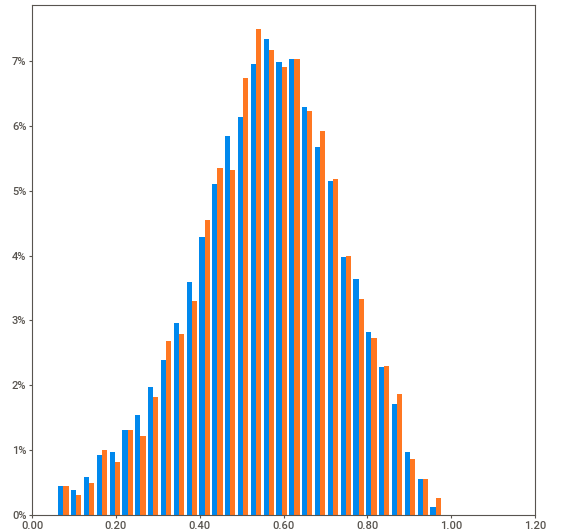
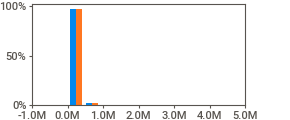
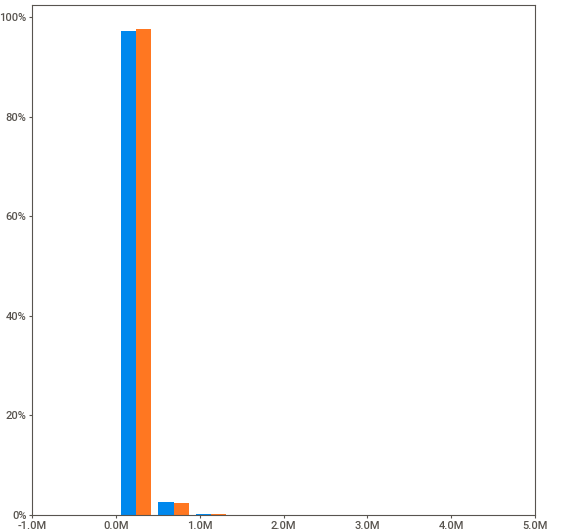
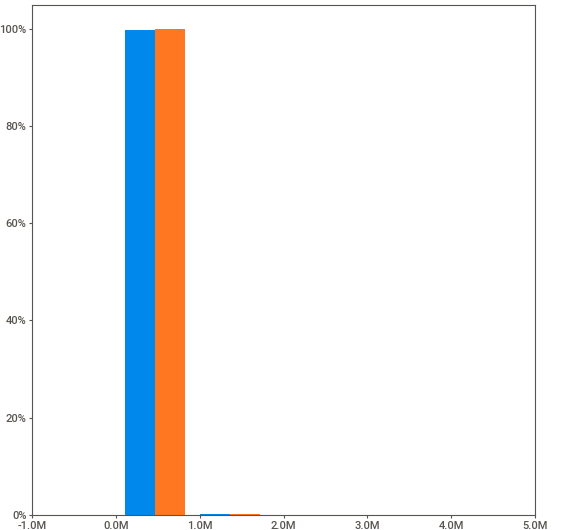
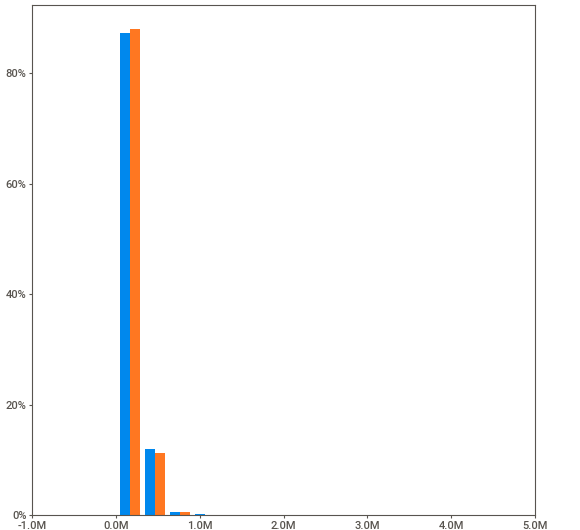
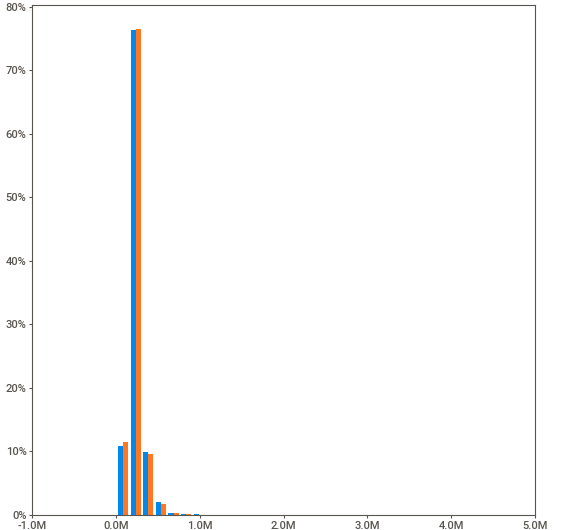
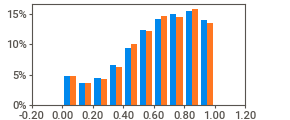
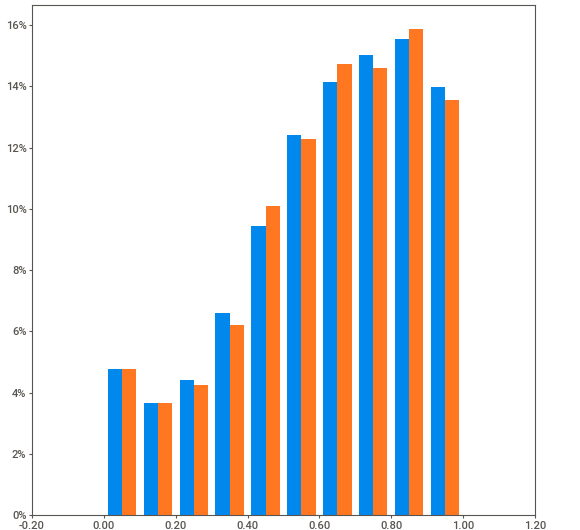
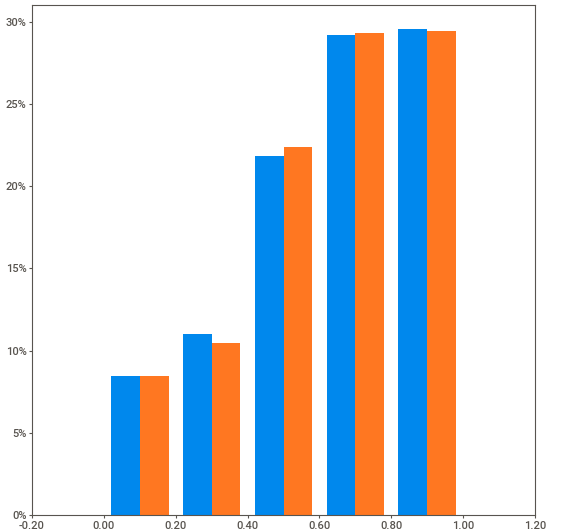
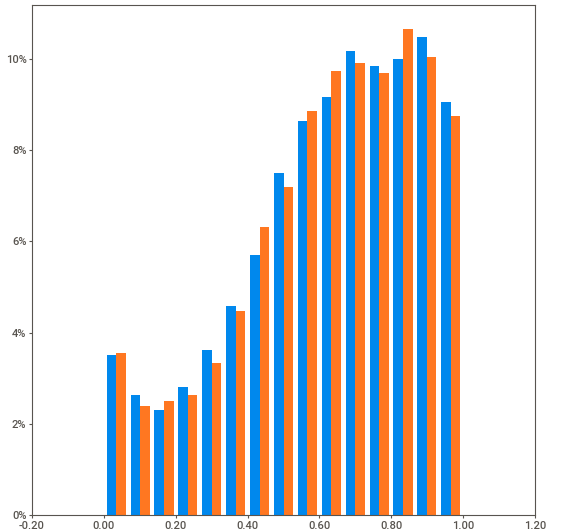
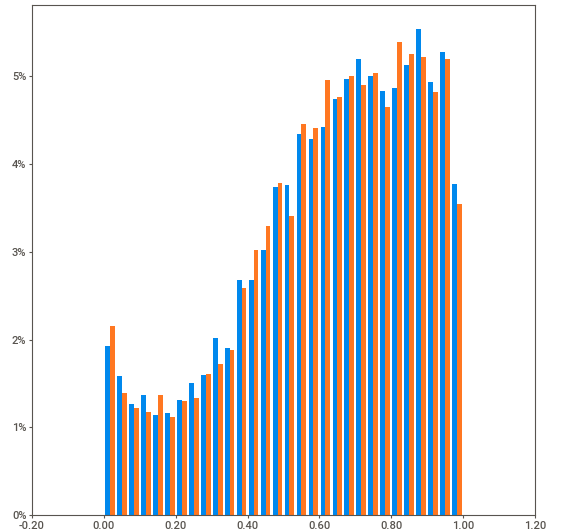
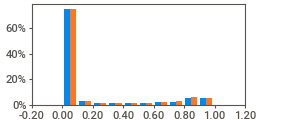
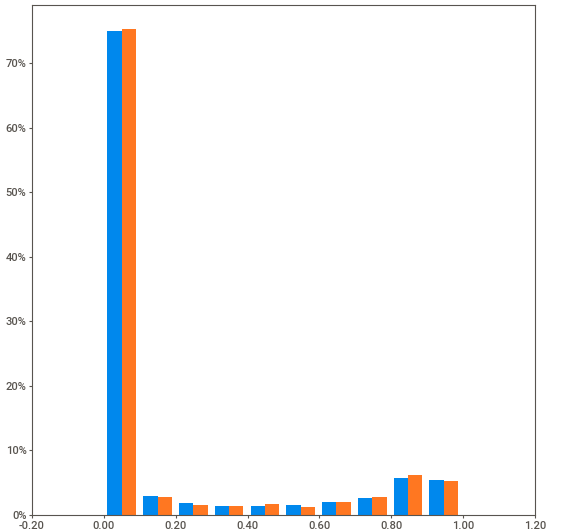
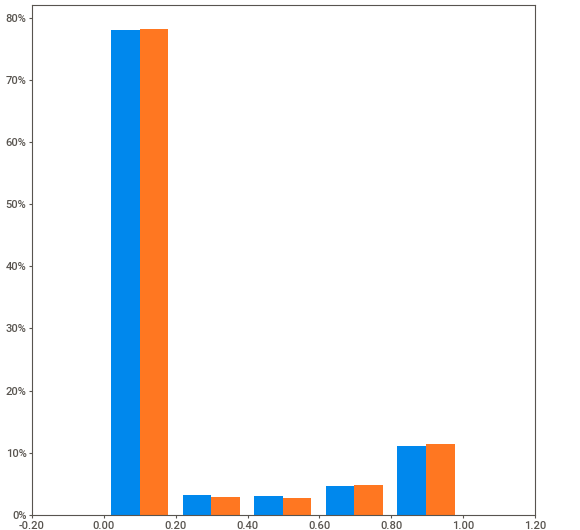
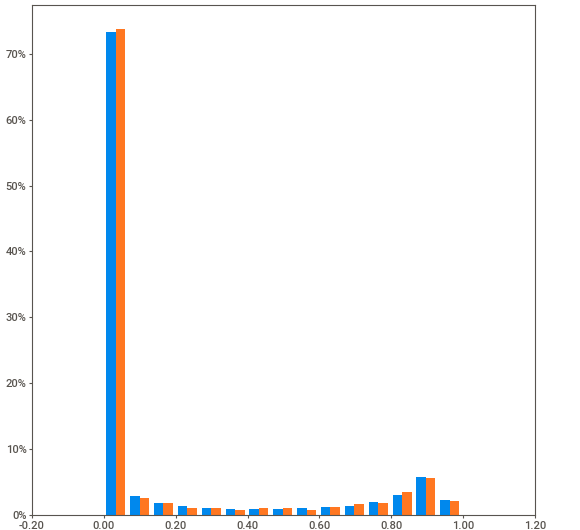
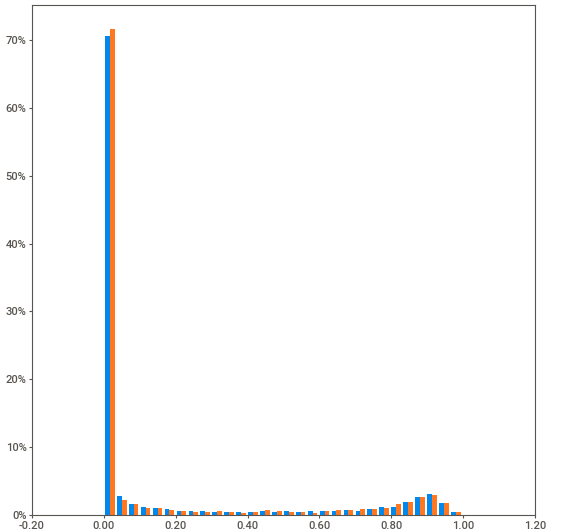
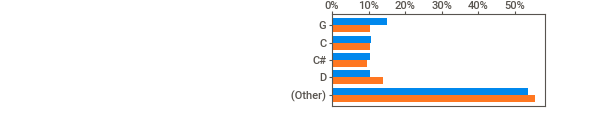
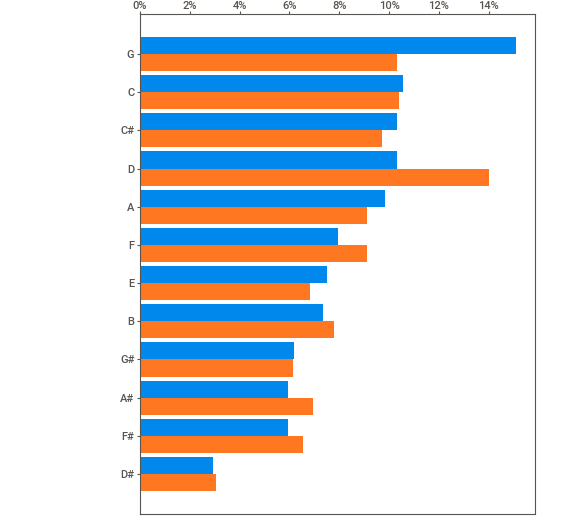
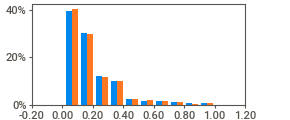
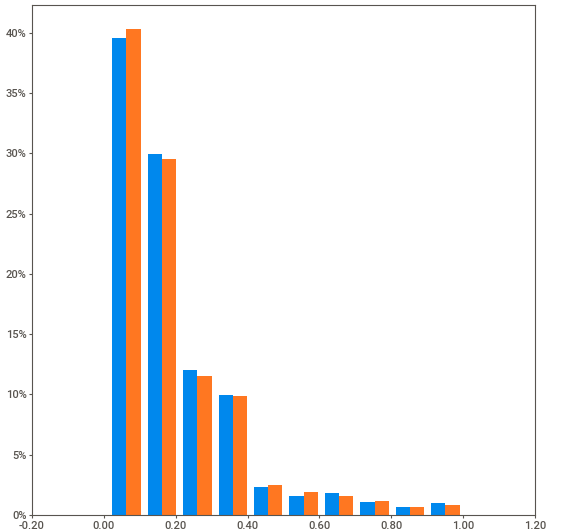
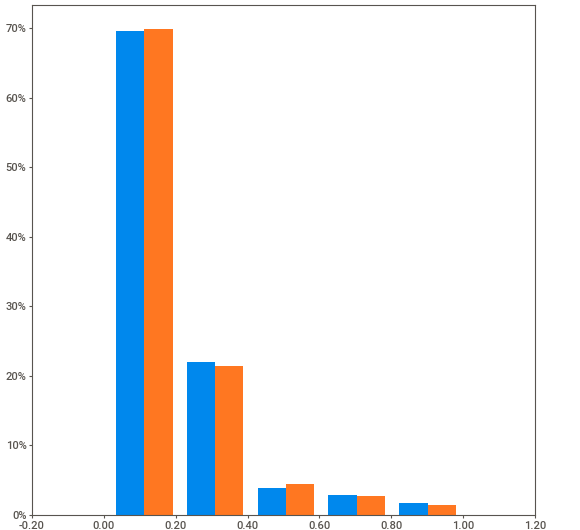
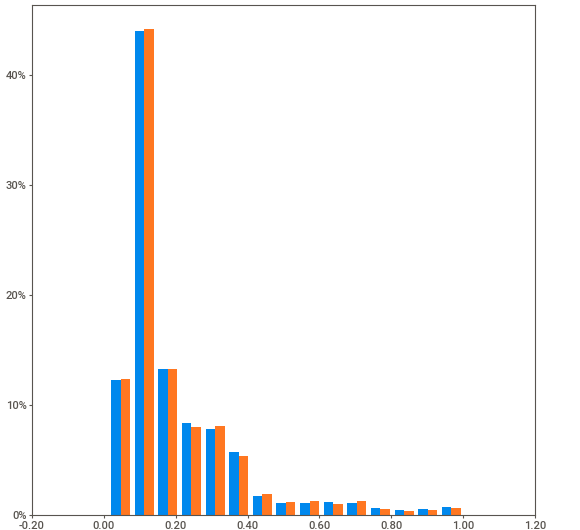
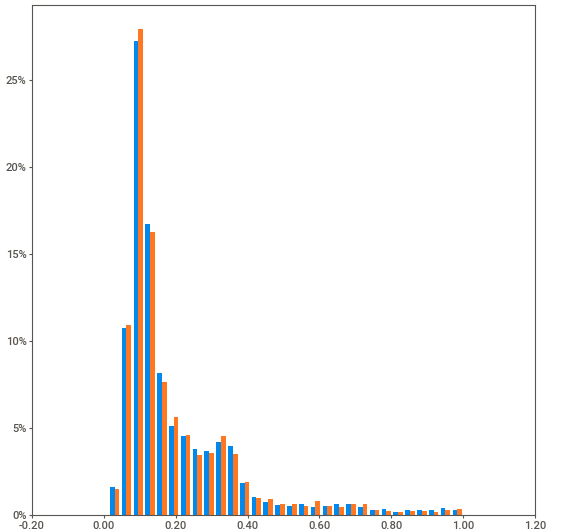
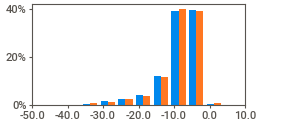
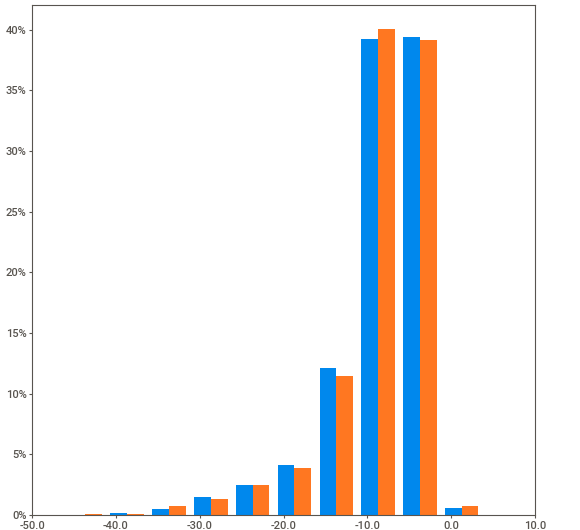
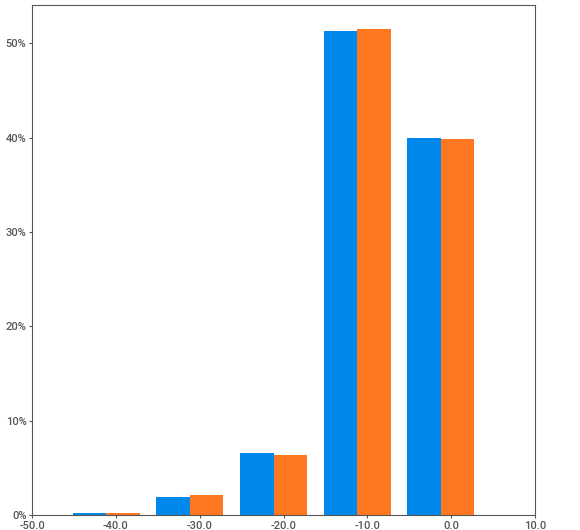
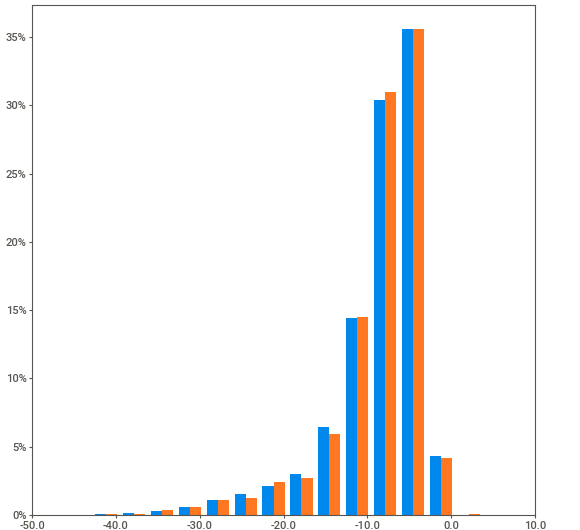
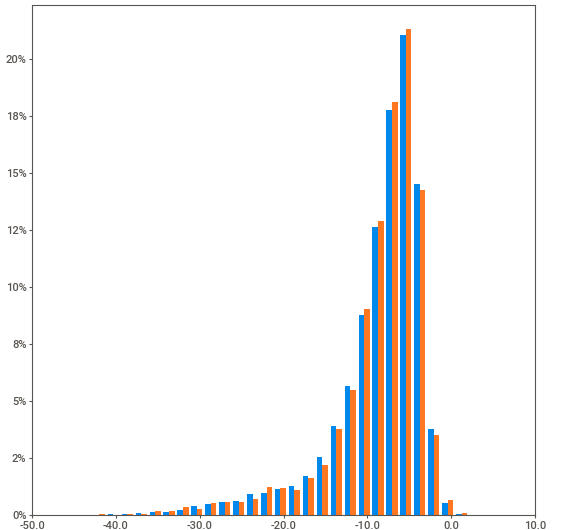
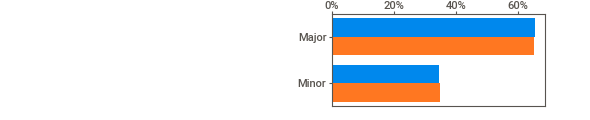
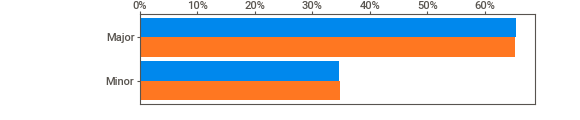
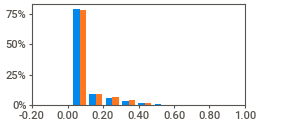
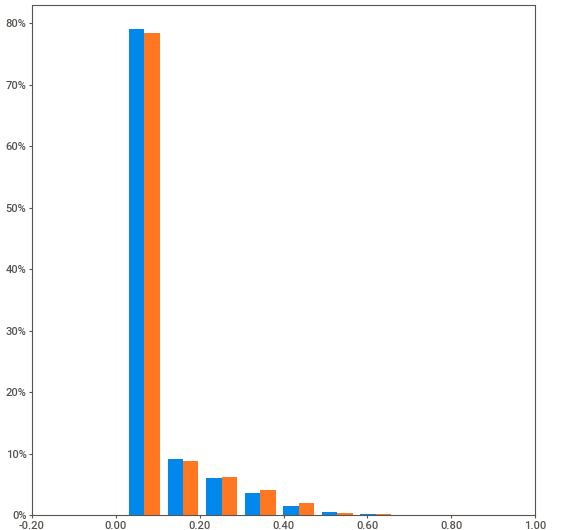
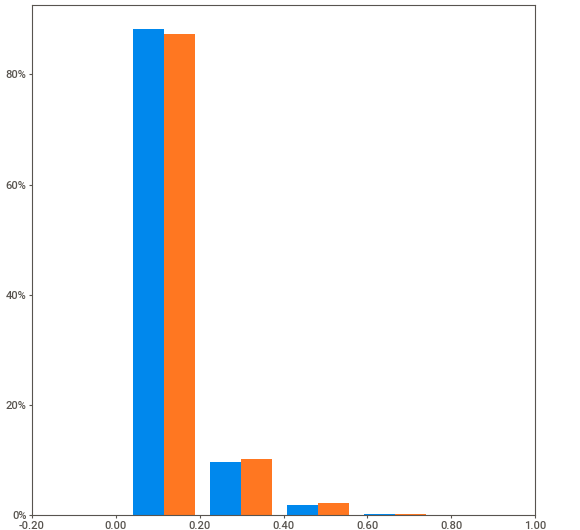
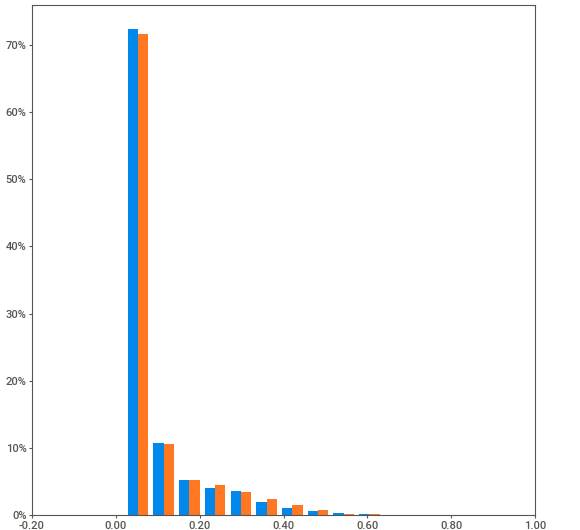
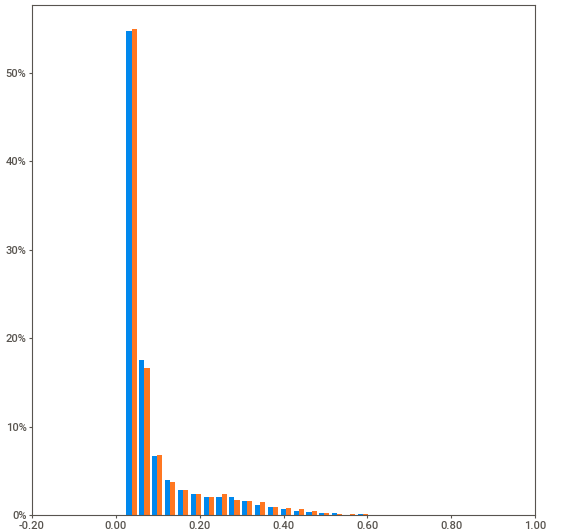
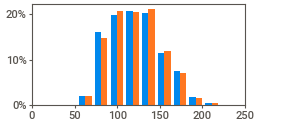
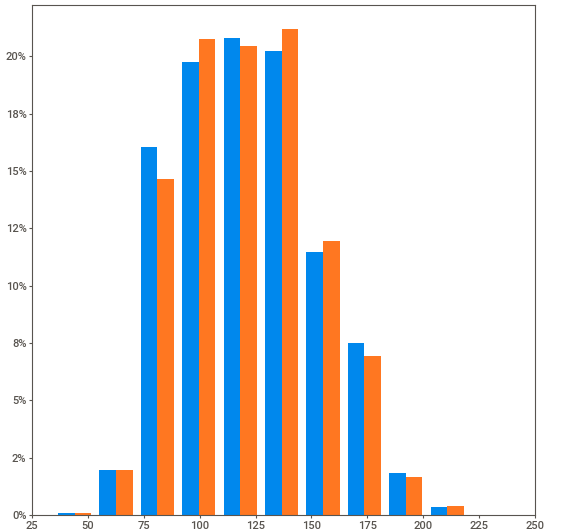
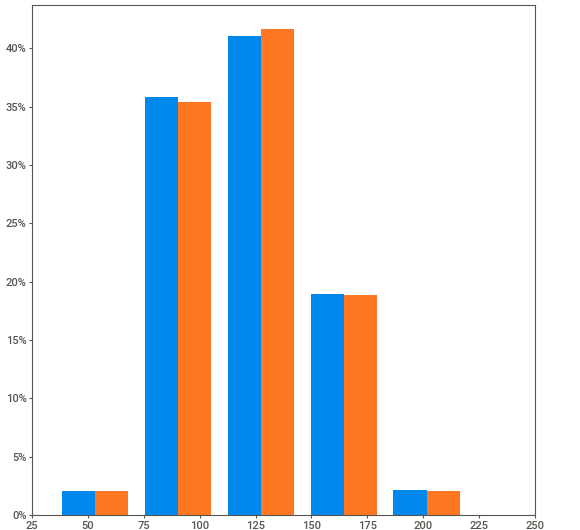
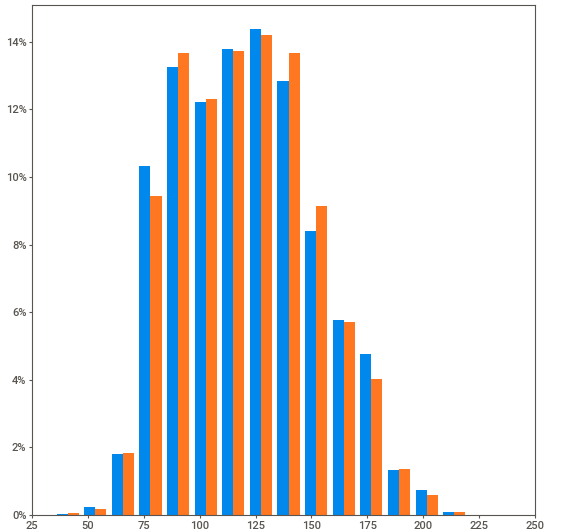
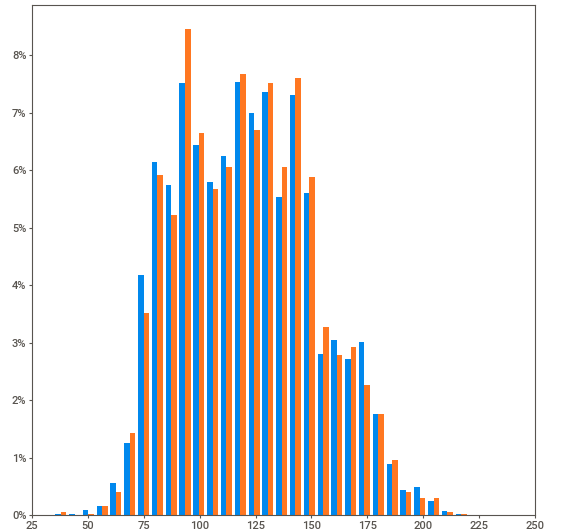
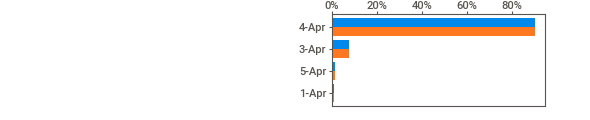
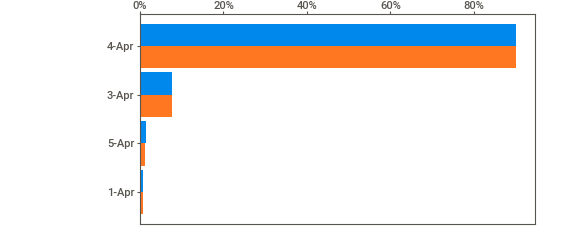
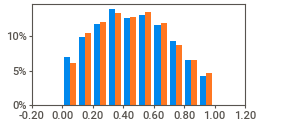
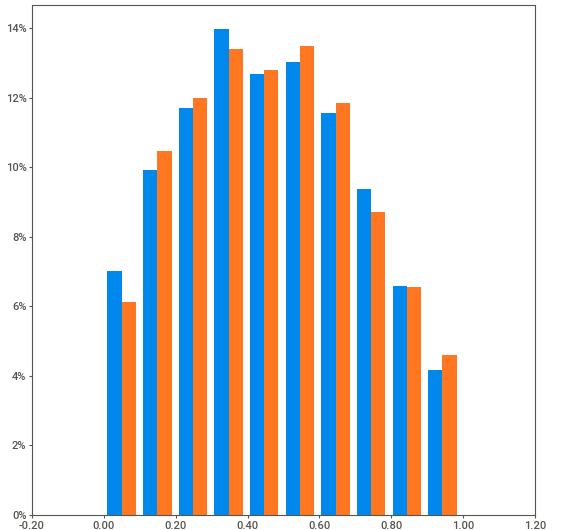
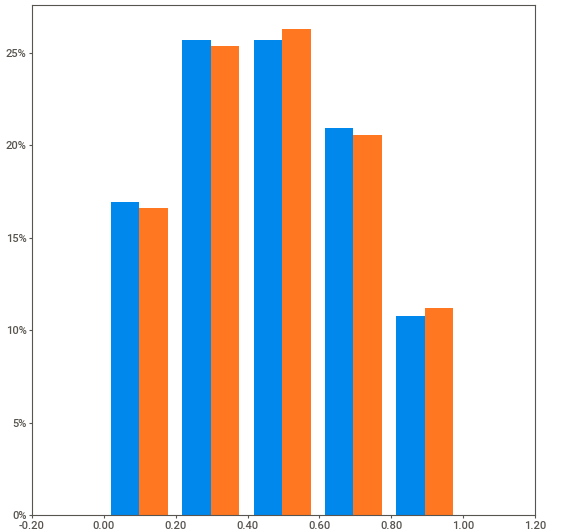
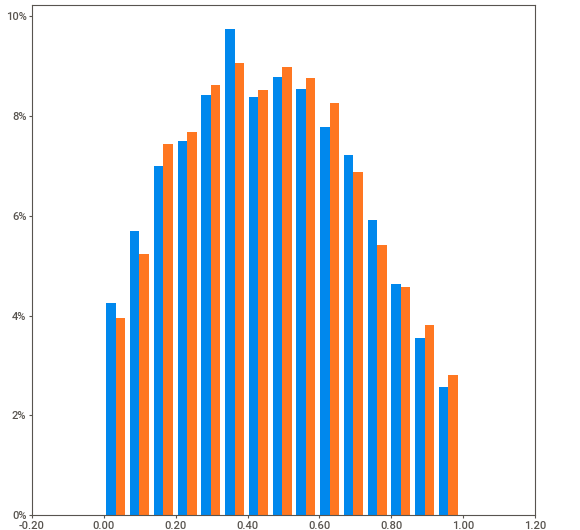
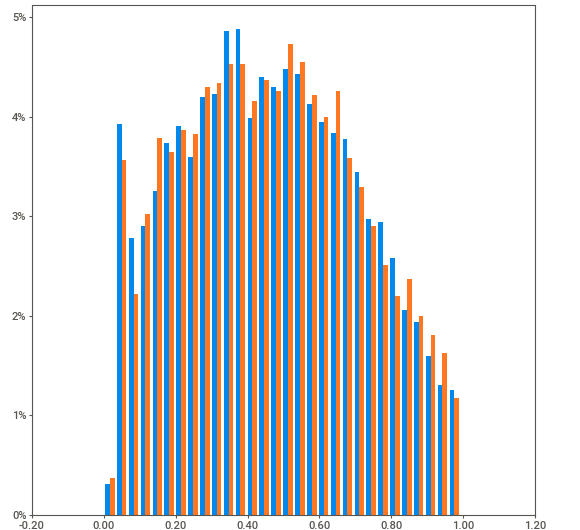
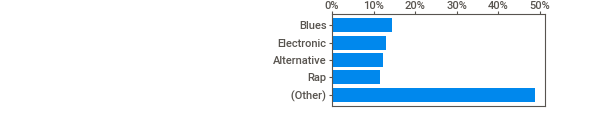
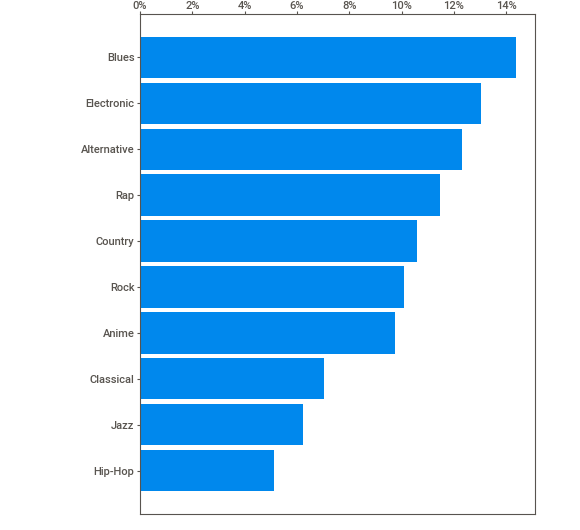
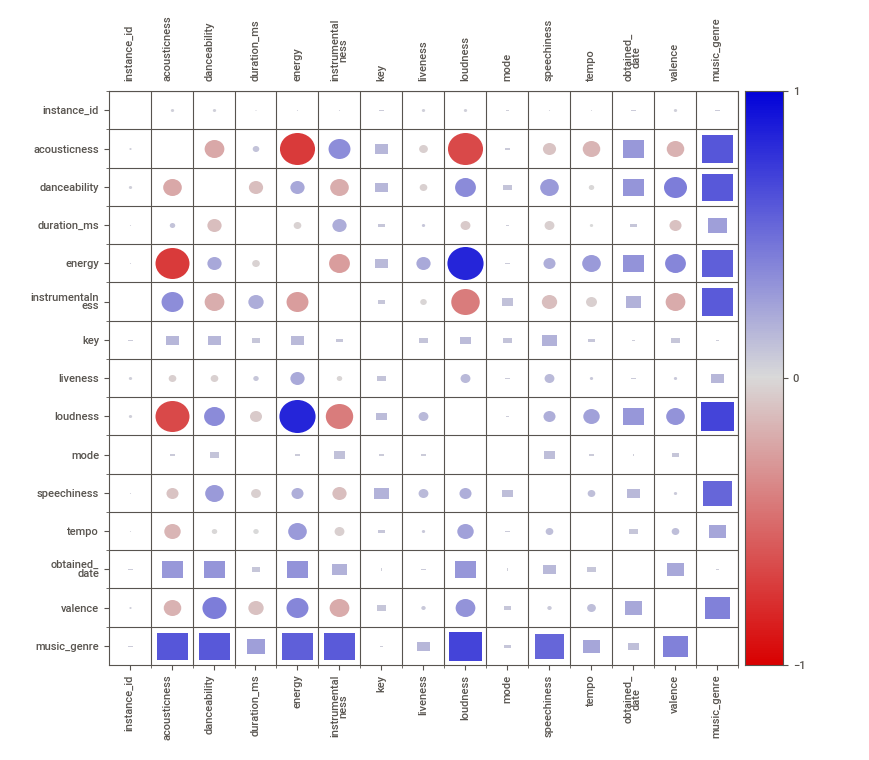
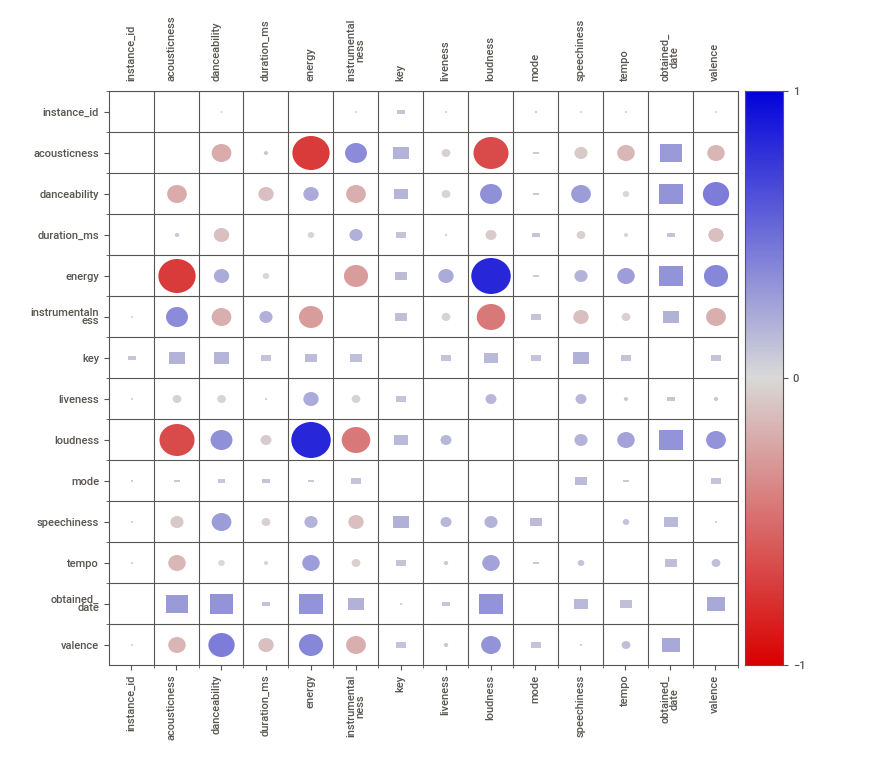

In [18]:
report = sv.compare(df_train, df_test)
report.show_notebook(w=None, h=None, scale=0.9, layout='widescreen', filepath=None)

Рассмотрим числовые колонки на предмет выбросов и аномалий.

In [19]:
num_cols = df_train.select_dtypes(include='float64').columns.tolist()
num_cols

['acousticness',
 'danceability',
 'duration_ms',
 'energy',
 'instrumentalness',
 'liveness',
 'loudness',
 'speechiness',
 'tempo',
 'valence']

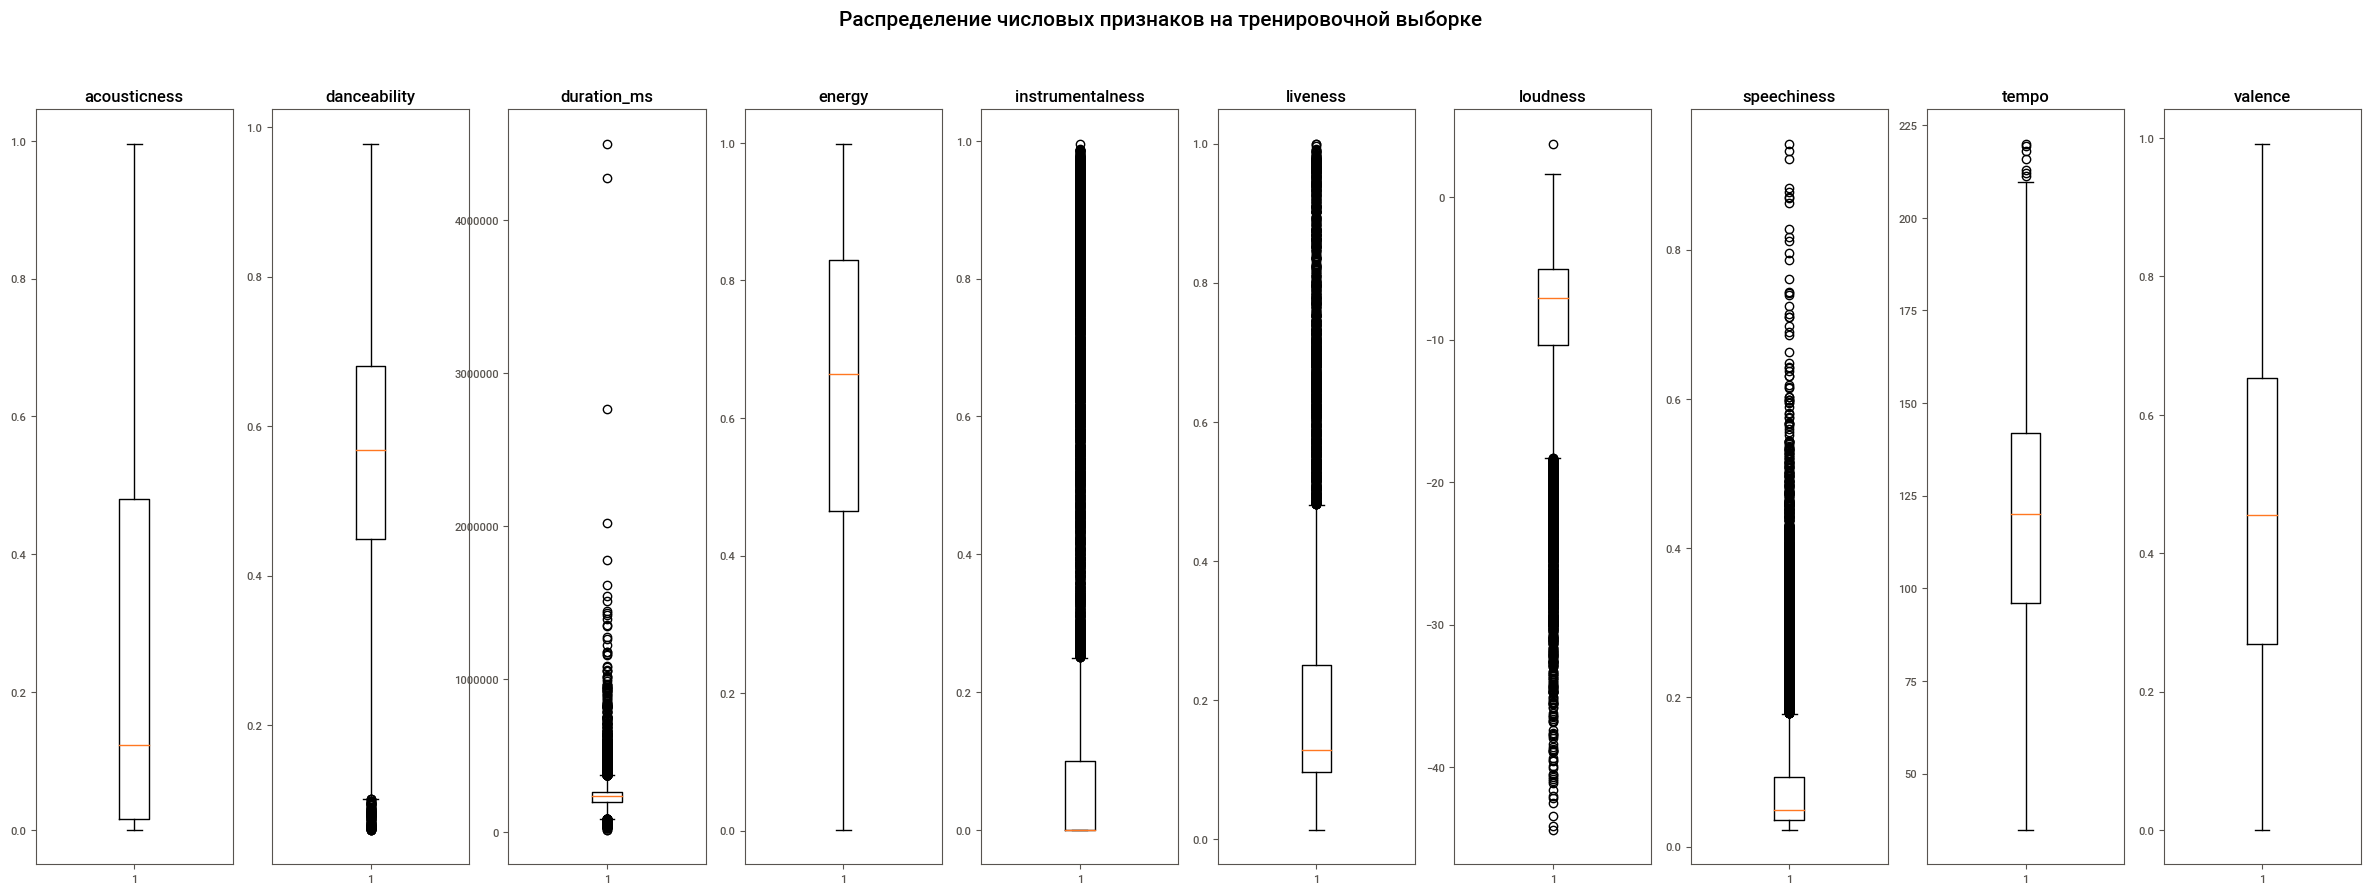

In [20]:
fig, axs = plt.subplots(1, 10)
ax = axs.ravel()
plt.figure
fig.suptitle('Распределение числовых признаков на тренировочной выборке', fontsize=15)
fig.set_size_inches(30, 10)
for i, num in enumerate(num_cols):
    ax[i].boxplot(df_train[num])
    ax[i].set_title(num)
plt.show()

После чего перейдем к обработке выбросов и аномалий.

В столбце с продолжительностью треков оставим песни продолжительностью менее 1500000 мс.

In [21]:
df_train = df_train[df_train['duration_ms'] < 1500000]

Избавимся от явных выбросов в столбце с громкостью, оставив значения в диапазоне от -40 до 0 дБ.

In [22]:
df_train = df_train[(df_train['loudness'] > -40) & (df_train['loudness'] < 0)]

В столбце разговорности уберем значения выше 0,85.

In [23]:
df_train = df_train[df_train['speechiness'] < 0.85]

В столбце с темпом избавимся от явных выбросов, оставив значения в диапазоне от 10 до 240 Bpm.

In [24]:
df_train = df_train[(df_train['tempo'] > 10) & (df_train['tempo'] < 240)]

In [25]:
round((1 - (df_train.shape[0] / df_1.shape[0])) * 100, 2)

4.95

**Вывод по второму шагу:** в тренировочном датафрейме обнаружили явные дубликаты и избавились от них, заменили тип данных в столбце `instance_id` на `int`. После чего обнаружили аномальные значения в столбце с продолжительностью и исправили их. Затем выявили пропуски в столбцах `key` и `mode`, заполнив их наиболее часто встречающимися значениями; и в столбце`tempo`, для заполнения пропусков которого воспользовались интерполяцией. После чего провели исследование на предмет выбросов и избавились от них в столбцах с продолжительностью, громкостью, разговорностью и темпом. В результате обработки первоначальная таблица с данными уменьшилась на 4,95%, что не окажет влияние на адекватность исследования.

В следующем шаге можем перейти к подготовке данных для обучения моделей.

# 3. Подготовка данных для обучения моделей.

Так как все треки загружены в апреле, оставим только число, приведем данныек к типу `int`.

In [26]:
df_train['obtained_date'] = df_train['obtained_date'].apply(lambda x: x.split('-')[0]).astype(int)
df_test['obtained_date'] = df_test['obtained_date'].apply(lambda x: x.split('-')[0]).astype(int)

Для анализа названия песен в жанре `Anime` создадим функцию, которая будет выполнять поиск символов `Han`.

In [27]:
def han_search(track_name):
    if regex.search(r'\p{Han}', track_name):
        return 1
    return 0

Создадим две новых колонки с признаками.

In [28]:
df_train['is_han'] = df_train['track_name'].apply(han_search)
df_test['is_han'] = df_test['track_name'].apply(han_search)

Определим наиболее часто встречающиеся слова в названиях песен каждого жанра. На основе этого создадим дополнительные признаки, избавившись от столбца с названиями треков.

In [29]:
# группирую названия треков по жанрам и разбиваю названия треков на отдельные слова
df_group = pd.pivot_table(df_train, index=['music_genre', 'track_name'], values=['acousticness'], aggfunc='mean').reset_index()
df_group['track_name'] = df_group['track_name'].apply(lambda x: x.split())
df_group = df_group[['music_genre', 'track_name']]

In [30]:
# функция для анализа количества определенных слов в названиях песен в каждом жанре
def track_name_analysis(data):
    res = pd.DataFrame()
    for i in list(data['music_genre'].unique()):
        data_alt = data.query('music_genre == @i')
        # дропнул '-', 'the', 'The', т.к. их много везде независимо от жанра
        res_i = pd.DataFrame({i: pd.Series(data_alt['track_name'].sum()).value_counts().drop(['-', 'the', 'The']).head(10)})
        res = pd.concat([res, res_i], axis=1)
    return res

Итоговый датафрейм анализа слов по жанрам будет выглядеть следующим образом.

In [31]:
# избавились от жанра Anime, т.к. для его названий разработан отдельный признак из-за наличия в нем символов Han
df_track_name_analysis = track_name_analysis(df_group).fillna(0).drop('Anime', axis=1)
df_track_name_analysis

,Alternative,Blues,Classical,Country,Electronic,Hip-Hop,Jazz,Rap,Rock
(feat.,113.0,0.0,0.0,0.0,187.0,152.0,0.0,366.0,0.0
You,100.0,192.0,0.0,178.0,75.0,18.0,57.0,60.0,140.0
I,80.0,147.0,0.0,163.0,41.0,29.0,38.0,76.0,97.0
Me,71.0,122.0,0.0,110.0,59.0,32.0,39.0,87.0,96.0
My,64.0,111.0,0.0,83.0,0.0,24.0,35.0,67.0,61.0
It,55.0,0.0,0.0,85.0,48.0,26.0,0.0,66.0,53.0
In,52.0,88.0,0.0,62.0,0.0,0.0,29.0,41.0,54.0
of,49.0,0.0,0.0,0.0,0.0,0.0,27.0,0.0,0.0
Of,46.0,0.0,0.0,0.0,0.0,0.0,32.0,0.0,48.0
Your,42.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Оценим важность слов для каждого жанра. Создадим столбцы с жанрами, значения которых будут заполнены суммой коэффициентов встречающихся слов.

In [32]:
def word_importance_features(data):
    df_group['track_name'] = df_group['track_name'].apply(lambda x: [word for word in x])

    data['track_name'] = data['track_name'].apply(lambda x: x.split())

    for genre in df_group[df_group['music_genre'] != 'Anime']['music_genre'].unique():
        words = df_track_name_analysis[genre].index.tolist()
        for word in words:
            data[word] = data['track_name'].apply(lambda x: 1 if word in x else 0)

    for genre in df_group[df_group['music_genre'] != 'Anime']['music_genre'].unique():
        words = df_track_name_analysis[genre].index.tolist()
        data[genre.lower() + '_prediction'] = data.apply(lambda row: sum(row[word] * df_track_name_analysis.at[word, genre] for word in words), axis=1)

In [33]:
pd.set_option('display.max_columns', None)

In [34]:
word_importance_features(df_train)
word_importance_features(df_test)

Избавимся от лишних столбцов.

In [35]:
df_train = df_train.drop('track_name', axis=1)
df_train = df_train.drop(df_track_name_analysis.index.tolist(), axis=1)
df_train

,instance_id,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre,is_han,alternative_prediction,blues_prediction,classical_prediction,country_prediction,electronic_prediction,hip-hop_prediction,jazz_prediction,rap_prediction,rock_prediction
0,25143,0.48000,0.670,182653.000000,0.351,0.017600,D,0.1150,-16.842,Major,0.0463,101.384,4,0.450,Country,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,26091,0.24300,0.452,187133.000000,0.670,0.000051,A,0.1080,-8.392,Minor,0.0352,113.071,4,0.539,Rock,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,77021,0.05580,0.847,255987.000000,0.873,0.000003,G#,0.3250,-4.805,Minor,0.0804,116.007,4,0.966,Hip-Hop,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,20852,0.22700,0.742,195333.000000,0.575,0.000002,C,0.1760,-5.550,Major,0.0487,76.494,4,0.583,Alternative,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,43934,0.10200,0.308,392893.000000,0.590,0.371000,D,0.1120,-11.703,Major,0.0345,145.758,4,0.496,Blues,0,0.0,93.0,0.0,0.0,0.0,0.0,39.0,0.0,130.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20389,47396,0.71900,0.725,245043.336927,0.483,0.000000,G,0.0797,-13.314,Minor,0.0438,87.413,4,0.942,Jazz,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20390,44799,0.19000,0.482,198933.000000,0.362,0.005620,F#,0.0913,-10.358,Minor,0.0299,76.879,4,0.174,Rock,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20391,33350,0.00061,0.663,220947.000000,0.886,0.000025,D,0.2840,-4.149,Major,0.0358,146.803,4,0.942,Alternative,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20392,77920,0.00310,0.914,162214.000000,0.515,0.000000,C#,0.1050,-9.934,Major,0.3560,150.016,4,0.215,Rap,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [36]:
df_test = df_test.drop('track_name', axis=1)
df_test = df_test.drop(df_track_name_analysis.index.tolist(), axis=1)
df_test

,instance_id,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,is_han,alternative_prediction,blues_prediction,classical_prediction,country_prediction,electronic_prediction,hip-hop_prediction,jazz_prediction,rap_prediction,rock_prediction
0,48564,0.301000,0.757,146213.000000,0.679,0.00000,A#,0.3030,-7.136,Minor,0.3560,90.361,4,0.895,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,72394,0.538000,0.256,240360.000000,0.523,0.00832,G#,0.0849,-5.175,Major,0.0294,78.385,4,0.318,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,88081,0.005830,0.678,284000.000000,0.770,0.00000,A,0.1090,-4.399,Minor,0.2220,90.000,4,0.412,0,71.0,122.0,0.0,110.0,59.0,32.0,39.0,87.0,96.0
3,78331,0.020300,0.592,177354.000000,0.749,0.00000,B,0.1220,-4.604,Major,0.0483,160.046,4,0.614,0,100.0,192.0,0.0,178.0,75.0,18.0,57.0,60.0,140.0
4,72636,0.000335,0.421,241505.422876,0.447,0.01480,D,0.0374,-8.833,Major,0.2020,73.830,4,0.121,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5094,50532,0.108000,0.558,163049.000000,0.767,0.00000,E,0.0954,-4.561,Minor,0.0491,158.019,4,0.715,0,55.0,0.0,0.0,85.0,48.0,26.0,0.0,66.0,53.0
5095,26255,0.131000,0.435,196216.000000,0.641,0.00000,A#,0.2730,-7.274,Major,0.1040,115.534,3,0.156,0,113.0,0.0,0.0,0.0,187.0,152.0,0.0,366.0,0.0
5096,67924,0.152000,0.756,243373.000000,0.787,0.00000,D,0.2050,-7.423,Major,0.2400,123.405,4,0.459,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5097,79778,0.001450,0.489,185600.000000,0.974,0.63800,F#,0.1230,-2.857,Minor,0.0381,150.036,4,0.665,0,0.0,0.0,0.0,0.0,242.0,0.0,0.0,0.0,0.0


Далее перейдем к проверке получившихся признаков на мультиколлениарность средствами библиотеки `phik`. После чего сформируем окончательный набор признаков.

In [37]:
phik_overview = df_train.phik_matrix()

interval columns not set, guessing: ['instance_id', 'acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'obtained_date', 'valence', 'is_han', 'alternative_prediction', 'blues_prediction', 'classical_prediction', 'country_prediction', 'electronic_prediction', 'hip-hop_prediction', 'jazz_prediction', 'rap_prediction', 'rock_prediction']


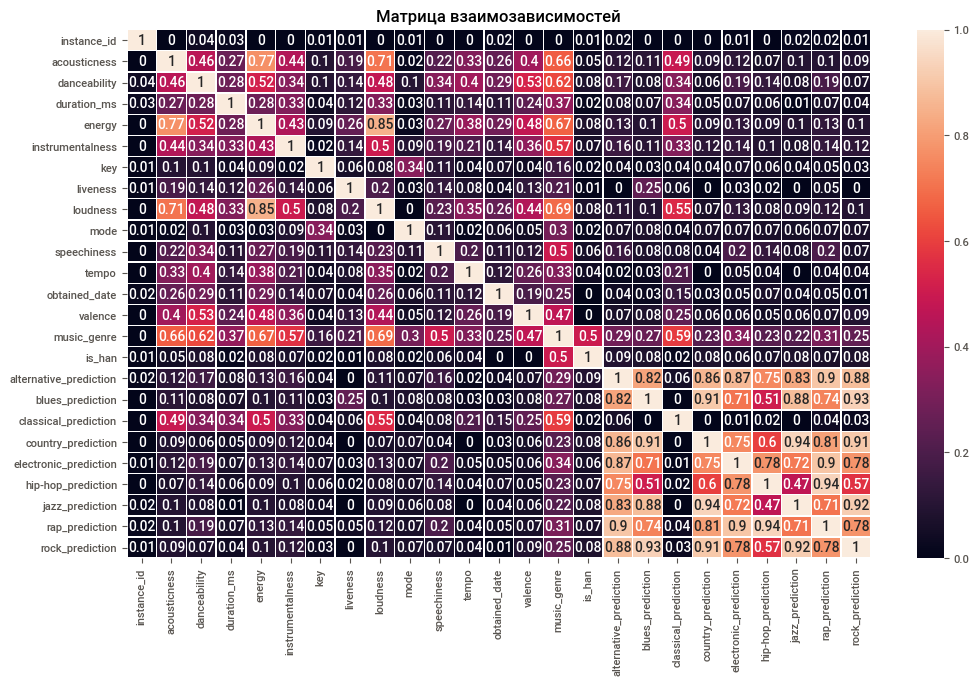

In [38]:
plt.figure(figsize=(12, 7))
corr_matrix = phik_overview
corr_matrix = np.round(corr_matrix, 2)
sns.heatmap(corr_matrix, annot=True, linewidth= 0.3)
plt.title('Матрица взаимозависимостей')
plt.show()

Колонки`alternative_prediction`,`country_prediction`, `blues_prediction`, `hip-hop_prediction` имеют слишком высокую корреляцию практически со всеми вновь созданными признаками. Уберем их при обучении и тестировании моделей.

**Вывод по третьему шагу:** Упростили `obtained_date`, оставив только число. Создали новые признаки на основе анализа названий треков. Избавились от колонок `alternative_prediction`,`country_prediction`, `blues_prediction`, `hip-hop_prediction` из-за высокой степени корреляции почти со всеми другими вновь созданными колонками. Тем самым был сформирован окончательный набор обучающих признаков.

Далее перейдем к созданию пайплайна, и проверке различных моделей с целью выбора лучшей.

# 4. Разработка модели ML

Для начала явно выделим числовые и категориальные признаки, а также целевое значение.

In [39]:
df_train.columns.tolist()

['instance_id',
 'acousticness',
 'danceability',
 'duration_ms',
 'energy',
 'instrumentalness',
 'key',
 'liveness',
 'loudness',
 'mode',
 'speechiness',
 'tempo',
 'obtained_date',
 'valence',
 'music_genre',
 'is_han',
 'alternative_prediction',
 'blues_prediction',
 'classical_prediction',
 'country_prediction',
 'electronic_prediction',
 'hip-hop_prediction',
 'jazz_prediction',
 'rap_prediction',
 'rock_prediction']

In [40]:
cat_features = ['key',
 'mode',
 'obtained_date',
 'is_han']
num_features = ['acousticness',
 'danceability',
 'liveness',
 'speechiness',
 'duration_ms',
 'energy',
 'tempo',
 'instrumentalness',
 'valence',
 'classical_prediction',
 'electronic_prediction',
 'jazz_prediction',
 'rap_prediction',
 'rock_prediction']
target_column = 'music_genre'

После чего зададим датафреймы с данными признаками и разделим их на обучающую и тестовую части.

In [41]:
features = df_train[cat_features + num_features]
target = df_train[target_column]

features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.2, random_state=99)

Далее создадим числовой и категориальный пайплайны.

In [42]:
num_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='mean')),
    ('scale', StandardScaler())
])

cat_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('one-hot', OneHotEncoder(handle_unknown='ignore', sparse=False, drop='first'))
])

Теперь объединим признаки в один пайплайн.

In [43]:
col_trans = ColumnTransformer(transformers=[
    ('num_pipeline', num_pipeline, num_features),
    ('cat_pipeline', cat_pipeline, cat_features)
    ],
    remainder='drop',
    n_jobs=-1)

## 4.1 Дерево решений

Обучим модель, пайплайн для нее, подберем гиперпараметры при помощи `GridSearchCV` и оценим значение метрики `f1_micro`.

In [44]:
tree = DecisionTreeClassifier(random_state=99)

In [45]:
tree_pipeline = Pipeline(steps=[
    ('col_trans', col_trans),
    ('model', tree)
])

In [46]:
tree_params = {'model__max_depth': range(7, 15)}

In [47]:
gsc_tree = GridSearchCV(tree_pipeline, tree_params, scoring='f1_micro', n_jobs=-1, cv=5)

In [48]:
gsc_tree.fit(features_train, target_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('col_trans',
                                        ColumnTransformer(n_jobs=-1,
                                                          transformers=[('num_pipeline',
                                                                         Pipeline(steps=[('impute',
                                                                                          SimpleImputer()),
                                                                                         ('scale',
                                                                                          StandardScaler())]),
                                                                         ['acousticness',
                                                                          'danceability',
                                                                          'liveness',
                                                                          'speechiness',
                                                                          'duration_ms',
                                                                          'energy',
                                                                          'tempo',
                                                                          'instrumentalness',
                                                                          'valence',
                                                                          'classical_prediction',
                                                                          'electronic_prediction',...
                                                                          'rock_prediction']),
                                                                        ('cat_pipeline',
                                                                         Pipeline(steps=[('impute',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('one-hot',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore',
                                                                                                        sparse=False))]),
                                                                         ['key',
                                                                          'mode',
                                                                          'obtained_date',
                                                                          'is_han'])])),
                                       ('model',
                                        DecisionTreeClassifier(random_state=99))]),
             n_jobs=-1, param_grid={'model__max_depth': range(7, 15)},
             scoring='f1_micro')

In [49]:
gsc_tree.best_params_

{'model__max_depth': 9}

In [50]:
gsc_tree.best_score_

0.4215523330071142

# 4.2 Случайный лес

Проделаем те же самые шаги для модели случайного леса.

In [51]:
forest = RandomForestClassifier(random_state=99)

In [52]:
forest_pipeline = Pipeline(steps=[
    ('col_trans', col_trans),
    ('model', forest)
])

In [53]:
forest_params = ({'model__max_depth':range(9, 15),
            'model__n_estimators':range(200, 340, 20),
             })

In [54]:
gsc_forest = GridSearchCV(forest_pipeline, forest_params, scoring='f1_micro', n_jobs=-1, cv=5)

In [55]:
gsc_forest.fit(features_train, target_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('col_trans',
                                        ColumnTransformer(n_jobs=-1,
                                                          transformers=[('num_pipeline',
                                                                         Pipeline(steps=[('impute',
                                                                                          SimpleImputer()),
                                                                                         ('scale',
                                                                                          StandardScaler())]),
                                                                         ['acousticness',
                                                                          'danceability',
                                                                          'liveness',
                                                                          'speechiness',
                                                                          'duration_ms',
                                                                          'energy',
                                                                          'tempo',
                                                                          'instrumentalness',
                                                                          'valence',
                                                                          'classical_prediction',
                                                                          'electronic_prediction',...
                                                                         Pipeline(steps=[('impute',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('one-hot',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore',
                                                                                                        sparse=False))]),
                                                                         ['key',
                                                                          'mode',
                                                                          'obtained_date',
                                                                          'is_han'])])),
                                       ('model',
                                        RandomForestClassifier(random_state=99))]),
             n_jobs=-1,
             param_grid={'model__max_depth': range(9, 15),
                         'model__n_estimators': range(200, 340, 20)},
             scoring='f1_micro')

In [56]:
gsc_forest.best_params_

{'model__max_depth': 14, 'model__n_estimators': 280}

In [57]:
gsc_forest.best_score_

0.4967438593777386

## 4.3 Логистическая регрессия

Подберем гиперпараметры и оценим метрику для модели логистической регрессии.

In [58]:
regr = LogisticRegression(random_state=99, multi_class='ovr')

In [59]:
regr_pipeline = Pipeline(steps=[
    ('col_trans', col_trans),
    ('model', regr)
])

In [60]:
regr_params = ({'model__max_iter':range(1000, 11000, 1000),
            'model__solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
             })

In [61]:
gsc_regr = GridSearchCV(regr_pipeline, regr_params, scoring='f1_micro', n_jobs=-1, cv=5)

In [62]:
gsc_regr.fit(features_train, target_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('col_trans',
                                        ColumnTransformer(n_jobs=-1,
                                                          transformers=[('num_pipeline',
                                                                         Pipeline(steps=[('impute',
                                                                                          SimpleImputer()),
                                                                                         ('scale',
                                                                                          StandardScaler())]),
                                                                         ['acousticness',
                                                                          'danceability',
                                                                          'liveness',
                                                                          'speechiness',
                                                                          'duration_ms',
                                                                          'energy',
                                                                          'tempo',
                                                                          'instrumentalness',
                                                                          'valence',
                                                                          'classical_prediction',
                                                                          'electronic_prediction',...
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('one-hot',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore',
                                                                                                        sparse=False))]),
                                                                         ['key',
                                                                          'mode',
                                                                          'obtained_date',
                                                                          'is_han'])])),
                                       ('model',
                                        LogisticRegression(multi_class='ovr',
                                                           random_state=99))]),
             n_jobs=-1,
             param_grid={'model__max_iter': range(1000, 11000, 1000),
                         'model__solver': ['newton-cg', 'lbfgs', 'liblinear',
                                           'sag', 'saga']},
             scoring='f1_micro')

In [63]:
gsc_regr.best_params_

{'model__max_iter': 1000, 'model__solver': 'newton-cg'}

In [64]:
gsc_regr.best_score_

0.43090220059625955

# 4.4 CatBoost

Далее рассмотрим, какую метрику мы получим на тренировочной выборке при использовании CatBoost.

Создадим пул для последующего обучения модели.

In [65]:
pool = Pool(
            data=features_train,
            label=target_train,
            cat_features=cat_features
            )

Зададим параметры.

In [66]:
params = { 'leaf_estimation_method': 'Gradient',
    'learning_rate': 0.01,
    'max_depth': 2,
    'bootstrap_type': 'Bernoulli',
    'objective': 'MultiClass',
    'subsample': 0.66,
    'random_state': 99,
    'verbose': 0,
    'eval_metric' : 'TotalF1',
    'early_stopping_rounds' : 100}

Обучим модель.

In [67]:
model = CatBoostClassifier(**params)
model.fit(pool)

Зададим параметры кроссвалидации после чего выполним её.

In [68]:
cv_params = {'loss_function':'MultiClass',
             'iterations':150,
             'depth':2,
             'verbose':False,
             'random_state':99,
             'custom_loss':'TotalF1',
             'learning_rate': 0.1}

cv_df_train = cv(pool=pool,
                 params=cv_params,
                 fold_count=5,
                 shuffle=True,
                 verbose=False,
                 plot=True)

cv_df_train

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 1.47981826
bestIteration = 149

Training on fold [1/5]

bestTest = 1.475461544
bestIteration = 149

Training on fold [2/5]

bestTest = 1.472866828
bestIteration = 149

Training on fold [3/5]

bestTest = 1.466235153
bestIteration = 149

Training on fold [4/5]

bestTest = 1.474351113
bestIteration = 149



,iterations,test-MultiClass-mean,test-MultiClass-std,train-MultiClass-mean,train-MultiClass-std,test-TotalF1-mean,test-TotalF1-std,train-TotalF1-mean,train-TotalF1-std
0,0,2.236428,0.000925,2.236443,0.001454,0.138566,0.001830,0.138623,0.001853
1,1,2.194632,0.002892,2.194162,0.000946,0.181479,0.020994,0.182554,0.019893
2,2,2.154650,0.002585,2.154093,0.002163,0.205062,0.009704,0.206824,0.012576
3,3,2.119442,0.002002,2.118264,0.001900,0.207113,0.010161,0.208825,0.012160
4,4,2.089349,0.003336,2.087947,0.004007,0.225053,0.021792,0.227981,0.020750
...,...,...,...,...,...,...,...,...,...
145,145,1.477335,0.004529,1.454091,0.002439,0.434226,0.001963,0.444226,0.002182
146,146,1.476599,0.004905,1.453158,0.002233,0.434047,0.001905,0.444555,0.002097
147,147,1.475829,0.004797,1.452288,0.002398,0.434296,0.002734,0.445268,0.002321
148,148,1.474755,0.004933,1.451236,0.002404,0.434748,0.002264,0.445225,0.002345


In [69]:
model.get_best_score()

{'learn': {'TotalF1': 0.3953145466269739, 'MultiClass': 1.5850384173719778}}

Обучим лучшую модель.

In [70]:
best_model = CatBoostClassifier(
    random_seed=99,
    iterations=int(model.tree_count_ * 1.2),
)
best_model.fit(
    features_train,
    target_train,
    cat_features=cat_features,
    verbose=False
)

Рассчитаем F1-меру для нее.

In [71]:
predictions = best_model.predict(features_train)
f1_score(target_train, predictions, average='micro')

0.7263816341007288

**Вывод по четвертому шагу:** обучили 4 модели. Дерево решения показало значение метрики равное 0,42, случайный лес - 0,49, логистическая регрессия - 0,43. Лучшей оказалась модель CatBoost, которая показала результат на тренировочной выборке равный 0,73.

Далее перейдем к проверке лучшей модели на тестовой выборке.

# 5. Итоговая оценка качества предсказания лучшей модели

In [72]:
test_predictions = best_model.predict(features_test)
f1_score(target_test, test_predictions, average='micro')

0.501418622646376

На тестовой выборке точность предсказания просела до 0,5.

Далее перейдем к предсказаниям на представленной в задании тестовой выборке и сформируем набор данных для загрузки на Kaggle.

In [73]:
genres = best_model.predict(df_test[cat_features + num_features])
genres

array([['Rap'],
       ['Country'],
       ['Rap'],
       ...,
       ['Rap'],
       ['Electronic'],
       ['Blues']], dtype=object)

In [74]:
names = []
for group in genres:
    names.extend(group)

In [75]:
df_test['music_genre'] = names

In [76]:
df_test

,instance_id,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,is_han,alternative_prediction,blues_prediction,classical_prediction,country_prediction,electronic_prediction,hip-hop_prediction,jazz_prediction,rap_prediction,rock_prediction,music_genre
0,48564,0.301000,0.757,146213.000000,0.679,0.00000,A#,0.3030,-7.136,Minor,0.3560,90.361,4,0.895,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Rap
1,72394,0.538000,0.256,240360.000000,0.523,0.00832,G#,0.0849,-5.175,Major,0.0294,78.385,4,0.318,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Country
2,88081,0.005830,0.678,284000.000000,0.770,0.00000,A,0.1090,-4.399,Minor,0.2220,90.000,4,0.412,0,71.0,122.0,0.0,110.0,59.0,32.0,39.0,87.0,96.0,Rap
3,78331,0.020300,0.592,177354.000000,0.749,0.00000,B,0.1220,-4.604,Major,0.0483,160.046,4,0.614,0,100.0,192.0,0.0,178.0,75.0,18.0,57.0,60.0,140.0,Country
4,72636,0.000335,0.421,241505.422876,0.447,0.01480,D,0.0374,-8.833,Major,0.2020,73.830,4,0.121,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Alternative
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5094,50532,0.108000,0.558,163049.000000,0.767,0.00000,E,0.0954,-4.561,Minor,0.0491,158.019,4,0.715,0,55.0,0.0,0.0,85.0,48.0,26.0,0.0,66.0,53.0,Country
5095,26255,0.131000,0.435,196216.000000,0.641,0.00000,A#,0.2730,-7.274,Major,0.1040,115.534,3,0.156,0,113.0,0.0,0.0,0.0,187.0,152.0,0.0,366.0,0.0,Rap
5096,67924,0.152000,0.756,243373.000000,0.787,0.00000,D,0.2050,-7.423,Major,0.2400,123.405,4,0.459,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Rap
5097,79778,0.001450,0.489,185600.000000,0.974,0.63800,F#,0.1230,-2.857,Minor,0.0381,150.036,4,0.665,0,0.0,0.0,0.0,0.0,242.0,0.0,0.0,0.0,0.0,Electronic


Создадим итоговый набор данных для загрузки на Kaggle.

In [77]:
result = df_test[['instance_id', 'music_genre']]

In [78]:
result

,instance_id,music_genre
0,48564,Rap
1,72394,Country
2,88081,Rap
3,78331,Country
4,72636,Alternative
...,...,...
5094,50532,Country
5095,26255,Rap
5096,67924,Rap
5097,79778,Electronic


In [79]:
result.to_csv(r'result.csv', index= False)

# 6. Анализ важности признаков лучшей модели

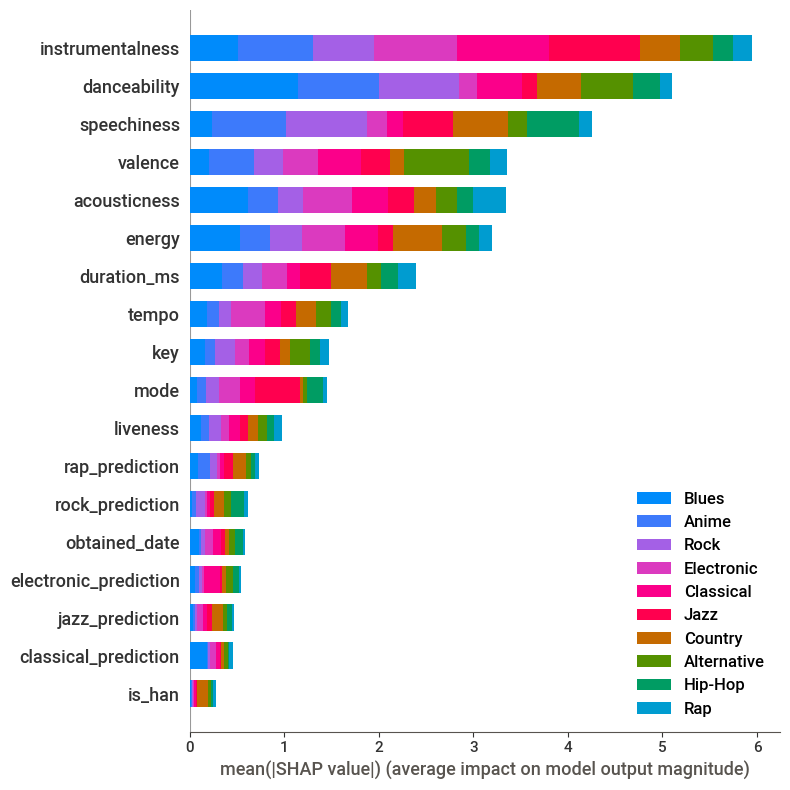

In [80]:
shap_test = shap.TreeExplainer(best_model).shap_values(df_test[cat_features + num_features])
shap.summary_plot(shap_test, df_test[cat_features + num_features],
                      max_display=25, plot_size=(8,8), class_names=df_test['music_genre'].unique())

**Вывод по шестому шагу:** по результатам анализа видим, что наибольшее влияние на предсказание жанра  оказывают инструментальность и танцевальность, наименьшее - наличие иероглифов. Наиболее часто предсказывается жанр - Блюз, значит большая часть признаков заточена под него. Наименее часто предсказываются Рэп и Хип-Хоп.

# 7. Общий вывод

**Вывод:** Для работы представлены две таблицы, первая содержит данные для обучения модели, вторая - для тестирования. Таблица тестирования содержит 15 столбцов с данными, из которых 10 - типа float64, 1 - типа int64 и 4 - типа object. Таблица с данными для обучения содержит столбцы в количестве 11 - типа float64 и 5 - типа object. Строки в таблицах имеют соотношение количества примерно 1 к 4. На первый взгляд в обеих таблицах видны пропуски в колонках `key`, `mode` и `tempo`. Столбец `instance_id` тренировочного датафрейма имеет тип `float`, что может свидетельствовать о наличии неверных данных в нем. Размер файлов является небольшим, поэтому нет необходимости в оптимизации занимаемого ими объема памяти.

В тренировочном датафрейме обнаружили явные дубликаты и избавились от них, заменили тип данных в столбце `instance_id` на `int`. После чего обнаружили аномальные значения в столбце с продолжительностью и исправили их. Затем выявили пропуски в столбцах `key` и `mode`, заполнив их наиболее часто встречающимися значениями; и в столбце`tempo`, для заполнения пропусков которого воспользовались интерполяцией. После чего провели исследование на предмет выбросов и избавились от них в столбцах с продолжительностью, громкостью, разговорностью и темпом. В результате обработки первоначальная таблица с данными уменьшилась на 4,95%, что не окажет влияние на адекватность исследования.

Упростили `obtained_date`, оставиви только число. Создали новые признаки на основе анализа названий треков. Избавились от колонок `alternative_prediction`,`country_prediction`, `blues_prediction`, `hip-hop_prediction` из-за высокой степени корреляции почти со всеми другими вновь созданными колонками. Тем самым был сформирован окончательный набор обучающих признаков.

После чего обучили 4 модели. Дерево решения показало значение метрики равное 0,42, случайный лес - 0,49, логистическая регрессия - 0,43. Лучшей оказалась модель CatBoost, которая показала результат на тренировочной выборке равный 0,73.

По результатам анализа видим, что наибольшее влияние на предсказание жанра  оказывают инструментальность и танцевальность, наименьшее - наличие иероглифов. Наиболее часто предсказывается жанр - Блюз, значит большая часть признаков заточена под него. Наименее часто предсказываются Рэп и Хип-Хоп.
